<h1 align="center"> Energy demand (Electricity price) Forecasting </h1>
<p>
</p>
<h2> Project and data set explanations: </h2>
<p>
</p>
<li> This is a time series forecasting problem where two distinct datasets of energy and weather data are used.
The energy consumption and weather data from various cities in Spain are combined to create a multivariate time series 
forecasting problem. The energy dataset contains features related to the generation of energy from different sources 
like fossil fuels, wind, and coal. On the other hand, the weather dataset contains features related to various weather 
metrics such as temperature, humidity, pressure, wind speed, etc. </li>
<p>
</p>
<li>The dataset includes a four-year record of weather data <a href="https://openweathermap.org/api">https://openweathermap.org/api</a> 
electrical consumption, pricing, and generation data for Spain <a href="https://transparency.entsoe.eu/dashboard/show">ENTOSE website</a> . The public ENTSOE portal was used to retrieve the consumption and generation data, while 
the Spanish TSO Red Electric España was used to obtain the settlement prices <a href="https://www.esios.ree.es/en/market-and-prices?date=27-03-2023#">TSO website</a>. 

<h2> Inspiration: </h2>
<p>
</p>
This dataset is noteworthy for its hourly data on electrical consumption, and the corresponding forecasts by the TSO 
for consumption and pricing, making it possible to compare prospective forecasts to the current state-of-the-art 
industry forecasts.

The following questions may be explored using this dataset:
<ul>
<li> How do the load and marginal supply curves appear? </li>
<li> What weather measurements and cities have the most significant influence on electrical demand, prices, and generation capacity?</li>
<li> Can we improve upon the TSO's 24-hour advance forecast? </li>
<li> Can we predict the electrical price by the time of day better than the TSO?</li>
<li> Can we forecast intraday price or electrical demand hour-by-hour?</li>
</ul>

<h2> Methods used in this project : </h2>
<h3> 1. Machine learning : </h3>
<ul>    
<li> XGboost Regressor </li>
</ul>
<h3> 2. Deep learning/Stacked models : </h3>
<ul>    
<li> GRU </li>
<li> LSTM </li>
<li> CNN </li>
<li> CNN-LSTM </li>
<li> LSTM-Attention </li>
</ul>
<h3> 3. Hybrid methods: </h3>
<ul>    
<li> GRU-XGBoost </li>
<li> LSTM-Attention-XGBoost </li>
</ul>


In [5]:
!pip install plotly

#tensorflow-addons version depends on the tensorflow and python version of the system,
#you can find the compatibility in this link

#https://stackoverflow.com/questions/61380552/unable-to-import-tensorflow-addons
!pip install tensorflow-addons==0.19.0

  Using cached plotly-6.3.0-py3-none-any.whl.metadata (8.5 kB)
Using cached plotly-6.3.0-py3-none-any.whl (9.8 MB)

   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]

ERROR: Could not find a version that satisfies the requirement tensorflow-addons==0.19.0 (from versions: none)
ERROR: No matching distribution found for tensorflow-addons==0.19.0


In [124]:
!pip install tensorflow-addons



Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement tensorflow-addons (from versions: none)
ERROR: No matching distribution found for tensorflow-addons


In [125]:
import tensorflow as tf
print(tf.__version__)


2.20.0


In [8]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import tensorflow as tf
# import tensorflow_addons as tfa


from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVR
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from keras import Sequential
from keras import layers
from keras.models import Model
from keras.layers import LSTM, BatchNormalization, Dropout, Dense, Flatten, Conv1D
from keras.layers import MaxPooling1D, GRU, Input,Masking, Concatenate, dot
from keras.optimizers import Adam, SGD
from keras.losses import MeanAbsoluteError
from keras.metrics import RootMeanSquaredError
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler

In [26]:
df_energy = pd.read_csv(
    "C:/Users/HARSHIL/Downloads/Electricity_Demand_and_Price_forecasting-main/Electricity_Demand_and_Price_forecasting-main/data/energy_dataset.csv"
)


In [27]:
df_energy.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


<li>Apparantly most stats for some features are constituted to be 0 or Nan. we will remove those columns. 
We will also remove day ahead forecasting columns.</li>

In [28]:
df_energy.describe().T

,count,mean,std,min,25%,50%,75%,max
generation biomass,35045.0,383.513540,85.353943,0.00,333.0000,367.00,433.00,592.00
generation fossil brown coal/lignite,35046.0,448.059208,354.568590,0.00,0.0000,509.00,757.00,999.00
generation fossil coal-derived gas,35046.0,0.000000,0.000000,0.00,0.0000,0.00,0.00,0.00
generation fossil gas,35046.0,5622.737488,2201.830478,0.00,4126.0000,4969.00,6429.00,20034.00
generation fossil hard coal,35046.0,4256.065742,1961.601013,0.00,2527.0000,4474.00,5838.75,8359.00
generation fossil oil,35045.0,298.319789,52.520673,0.00,263.0000,300.00,330.00,449.00
generation fossil oil shale,35046.0,0.000000,0.000000,0.00,0.0000,0.00,0.00,0.00
generation fossil peat,35046.0,0.000000,0.000000,0.00,0.0000,0.00,0.00,0.00
generation geothermal,35046.0,0.000000,0.000000,0.00,0.0000,0.00,0.00,0.00
generation hydro pumped storage aggregated,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
df_energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

In [30]:
# columns to be removed due to all 0 or Nan values
col_names = ['generation fossil coal-derived gas', 'generation fossil oil shale','generation fossil peat',
           'generation geothermal', 'generation hydro pumped storage aggregated', 'generation marine',
           'generation wind offshore', 'forecast wind offshore eday ahead', 'forecast solar day ahead',
            'forecast wind onshore day ahead']

In [31]:
df_energy = df_energy.drop(col_names, axis = 1)

In [32]:
# Checking Nans and duplicates in each columns
def check_Nans_Dups(df_input):
    
    print('Number of Nans in each column :')
    
    print(df_input.isnull().sum())
    print()
    print(f'Number of duplicates in the dataframe : {df_input.duplicated().sum()}')
    return

In [33]:
check_Nans_Dups(df_energy)

Number of Nans in each column :
time                                            0
generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind onshore                        18
total load forecast                             0
total load actual                              36
price day ahead                                 0
price actual                                    0
dtype: int64

Numb

In [34]:
df_energy['time'] = pd.to_datetime(df_energy['time'])
df_energy = df_energy.set_index('time')
df_energy

C:\Users\HARSHIL\AppData\Local\Temp\ipykernel_16300\980508139.py:1: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_energy['time'] = pd.to_datetime(df_energy['time'])


,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load forecast,total load actual,price day ahead,price actual
time,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+01:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,73.0,49.0,196.0,6378.0,26118.0,25385.0,50.10,65.41
2015-01-01 01:00:00+01:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,71.0,50.0,195.0,5890.0,24934.0,24382.0,48.10,64.92
2015-01-01 02:00:00+01:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,73.0,50.0,196.0,5461.0,23515.0,22734.0,47.33,64.48
2015-01-01 03:00:00+01:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,75.0,50.0,191.0,5238.0,22642.0,21286.0,42.27,59.32
2015-01-01 04:00:00+01:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,74.0,42.0,189.0,4935.0,21785.0,20264.0,38.41,56.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00+01:00,297.0,0.0,7634.0,2628.0,178.0,1.0,1135.0,4836.0,6073.0,63.0,95.0,85.0,277.0,3113.0,30619.0,30653.0,68.85,77.02
2018-12-31 20:00:00+01:00,296.0,0.0,7241.0,2566.0,174.0,1.0,1172.0,3931.0,6074.0,62.0,95.0,33.0,280.0,3288.0,29932.0,29735.0,68.40,76.16
2018-12-31 21:00:00+01:00,292.0,0.0,7025.0,2422.0,168.0,50.0,1148.0,2831.0,6076.0,61.0,94.0,31.0,286.0,3503.0,27903.0,28071.0,66.88,74.30


Text(0, 0.5, 'total load actual')

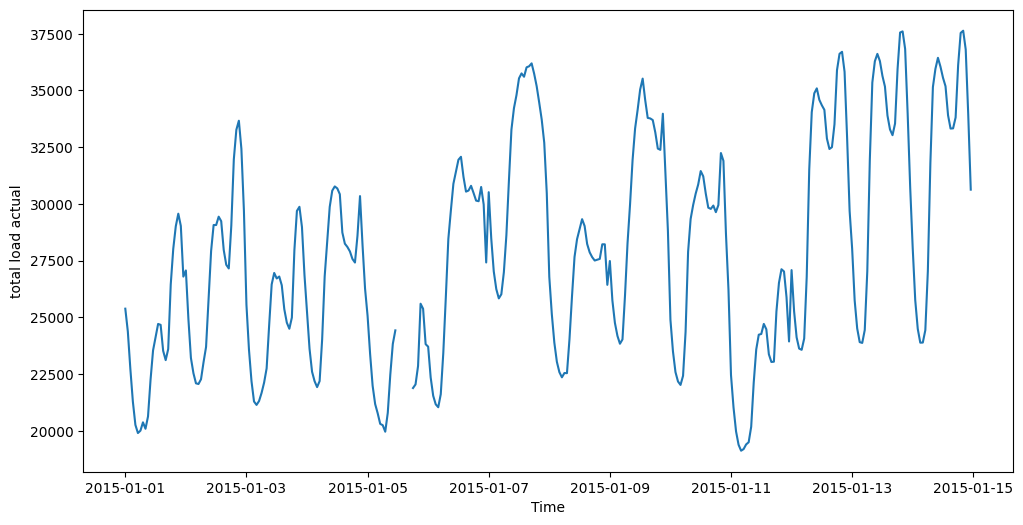

In [35]:
plt.figure(figsize=(12,6))
# plot total load actual for two weeks duration 
plt.plot(df_energy['total load actual'][:24*7*2])
plt.xlabel('Time')
plt.ylabel('total load actual')

<li> So, it seems there are not too many Nan values in dataframe.In general, if the number of missing values 
is relatively small and the time series has a regular frequency, interpolation methods such as linear or 
spline interpolation can be used to estimate the missing values. On the other hand, if the number of 
missing values is large or if the missing values are irregularly spaced, it may be better to remove 
them, as interpolating over large gaps can introduce noise and bias in the data. So we will linearly
interploate the nan values. </li>

In [36]:
df_energy[df_energy.isna().any(axis = 1)]

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load forecast,total load actual,price day ahead,price actual
time,,,,,,,,,,,,,,,,,,
2015-01-05 03:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21912.0,21182.0,35.20,59.68
2015-01-05 12:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23209.0,NaN,35.50,79.14
2015-01-05 13:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23725.0,NaN,36.80,73.95
2015-01-05 14:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23614.0,NaN,32.50,71.93
2015-01-05 15:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22381.0,NaN,30.00,71.50
2015-01-05 16:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21371.0,NaN,30.00,71.85
2015-01-05 17:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20760.0,NaN,30.60,80.53
2015-01-19 19:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38642.0,39304.0,70.01,88.95
2015-01-19 20:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38758.0,39262.0,69.00,87.94


In [37]:
df_energy.interpolate(method='linear', limit_direction='forward', inplace = True)

<li> So, there is no any NaN value in the data! </li>

In [38]:
df_energy.isnull().sum()

generation biomass                             0
generation fossil brown coal/lignite           0
generation fossil gas                          0
generation fossil hard coal                    0
generation fossil oil                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation nuclear                             0
generation other                               0
generation other renewable                     0
generation solar                               0
generation waste                               0
generation wind onshore                        0
total load forecast                            0
total load actual                              0
price day ahead                                0
price actual                                   0
dtype: int64

<strong> Feature Correlation </strong>

<li> Based on the feaure correlation,  There is a strong correlation between <strong>"generation fossil hard coal"</strong> and <strong>"generation fossil brown coal/lignite"</strong>. So with a common sense we can combine these two feature as a 
<strong>"generation fossil total"</strong> and remove them. </li>

<strong> Note : </strong> There is a very high correlation between <strong>Total load forecasting</strong> and <strong>total load actual.</strong> For now,
I will keep this for visulization part of this project but before feeding the data into model I will drop this column. 

In [39]:
def feat_corr(input_df):
    corr = input_df.corr()
    plt.figure(figsize=(15,12))
    #plot heat map
    g=sns.heatmap(corr,annot=True,cmap="RdYlGn", vmin=-1, vmax=1)
    plt.title('Feature Correlation')
    
    return plt.show()

In [54]:
def feat_corr(input_df):
    # Select only numeric columns
    corr = input_df.select_dtypes(include=['number']).corr()
    
    plt.figure(figsize=(15,12))
    g = sns.heatmap(corr, annot=True, cmap="RdYlGn", vmin=-1, vmax=1)
    plt.title('Feature Correlation')
    plt.show()


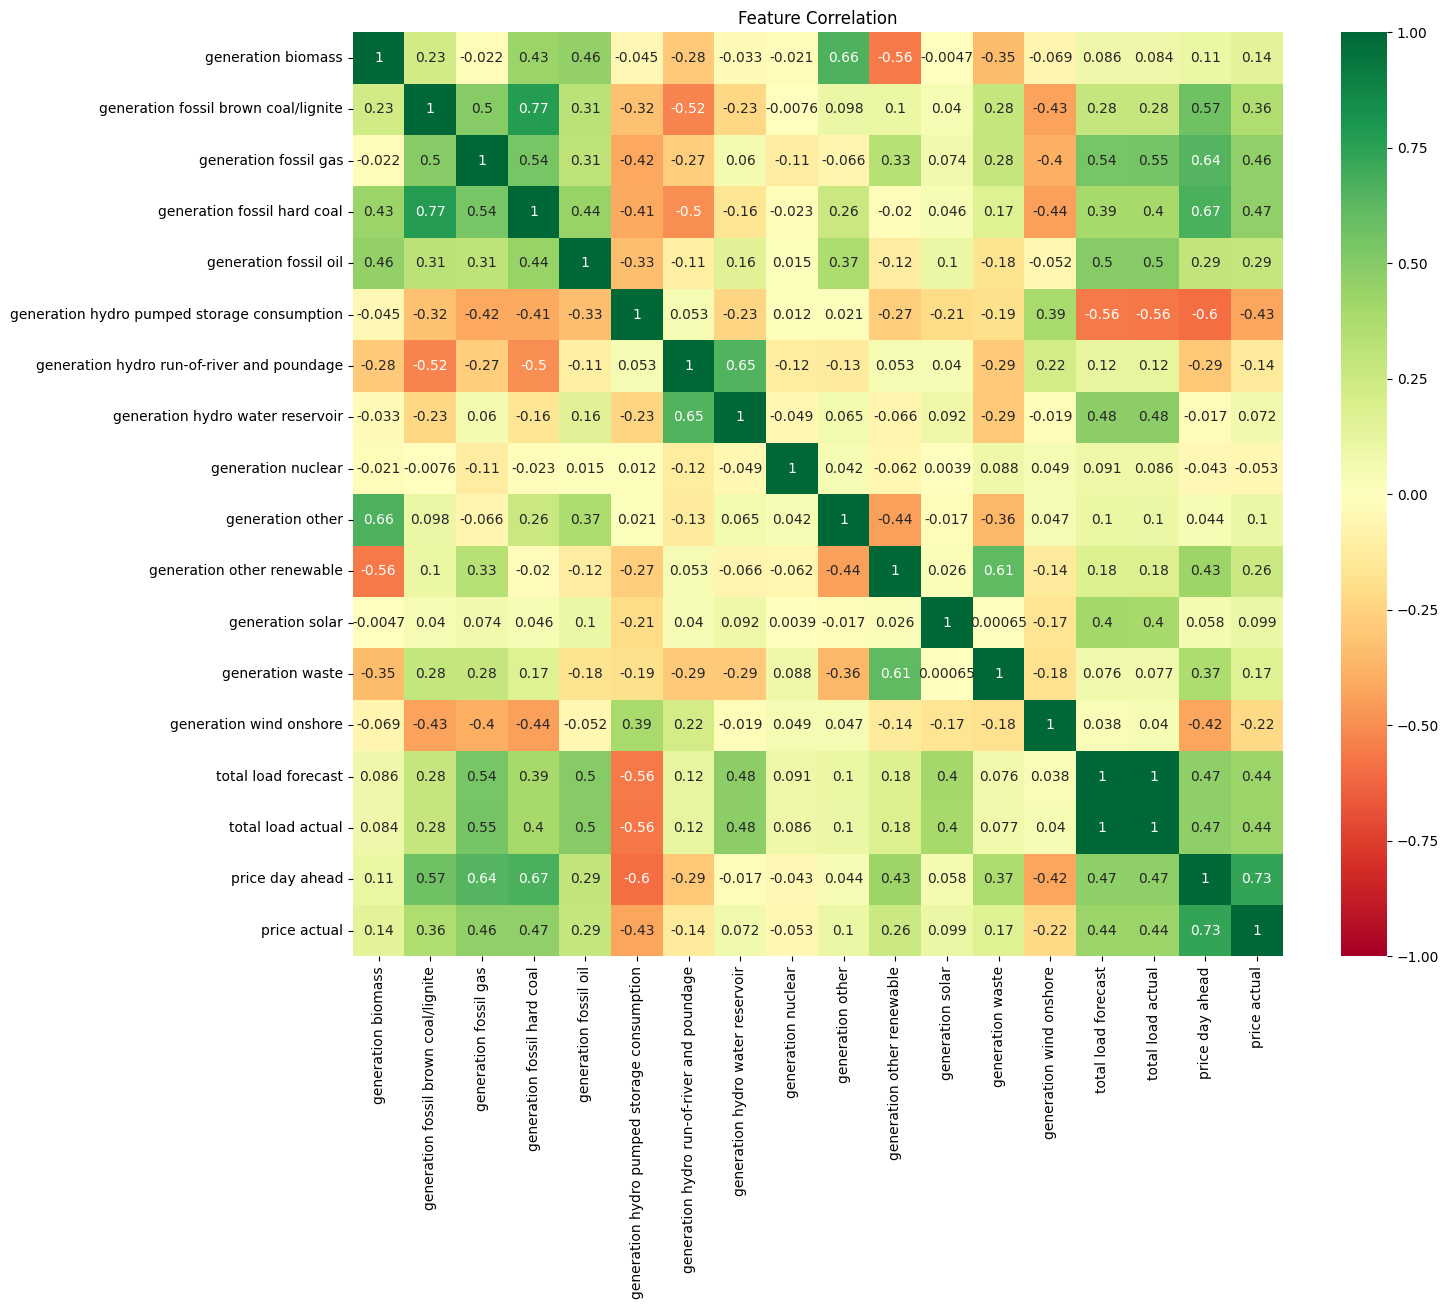

In [40]:
feat_corr(df_energy)

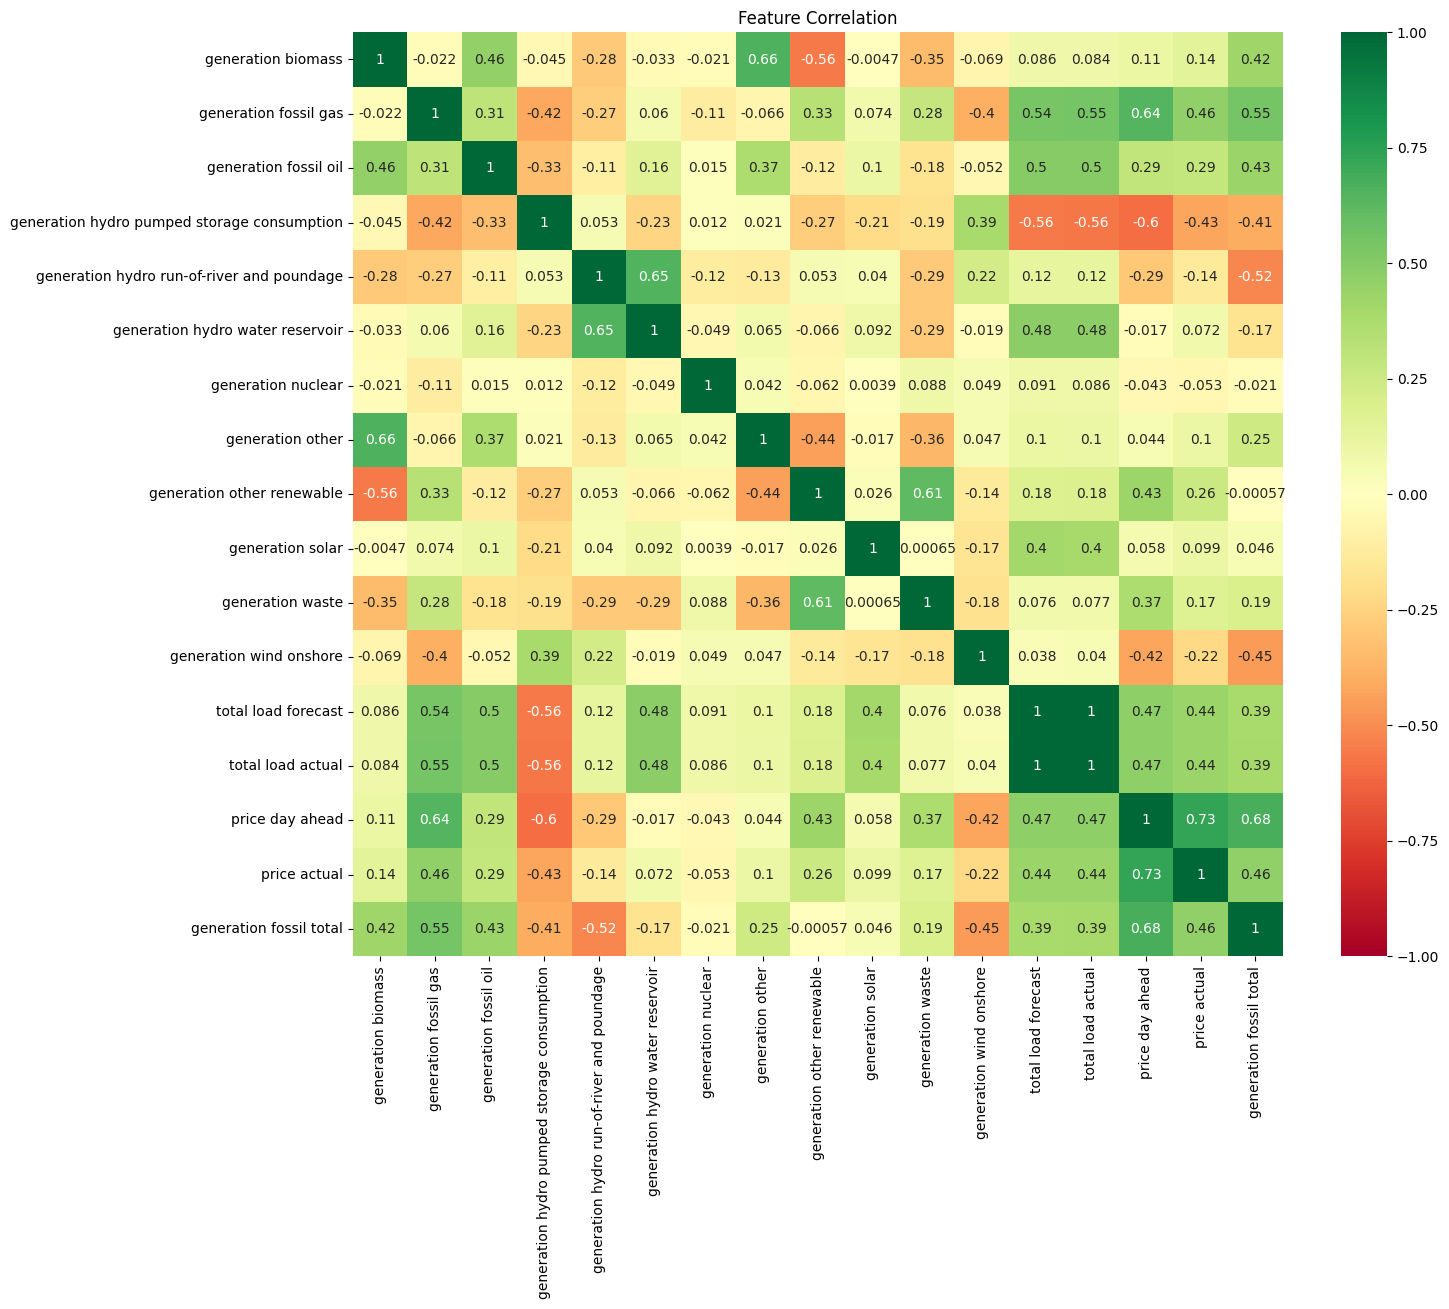

In [41]:
df_energy["generation fossil total"] = df_energy['generation fossil hard coal'] + df_energy['generation fossil brown coal/lignite']
df_energy.drop(['generation fossil hard coal', 'generation fossil brown coal/lignite'], axis = 1, inplace = True)
feat_corr(df_energy)

<h3> Weather dataset </h3>

In [60]:
df_weather = pd.read_csv("C:/Users/HARSHIL/Downloads/Electricity_Demand_and_Price_forecasting-main/Electricity_Demand_and_Price_forecasting-main/data/weather_features.csv")


In [61]:
df_weather.head()

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


<li> Based on a quick look at the dataframe we will notice that <strong>'weather_icon'</strong> seems useless feature.
Beside that colud cover that is reflected in <strong>'weather_main' and 'weather_description'</strong> can afftect the prediction, but since
this is hourly requirements and since their effect is reflected in measured temprerature, we can drop these two columns as well and instead 
we can keep <strong>'clouds_all'</strong>. But before deciding on which feature to drop, lets see the feature correlations.</li> 

In [62]:
df_temp = df_weather.copy(deep = True)
labels = ['weather_id', 'weather_main','weather_description','weather_icon']
for col in labels:
    df_temp[col] = LabelEncoder().fit_transform(df_weather[col])

<p>
</p>
<li> Apparantly there is strong correlation between the features that we talked about. Having strong correlation between 
features might cuase multicolinearity. So, we can drop <strong>'weather_icon', 'weather_main', 'weather_description', and 'weather_id'</strong> 
and just keep <strong>'clouds_all'</strong>. There is also a very strong correlation between 'temp', 'temp_min' and 'temp_max'. So we drop temp_max 
and temp_min and just keep <strong> 'temp'</strong>.</li>

In [63]:
df_weather.columns

Index(['dt_iso', 'city_name', 'temp', 'temp_min', 'temp_max', 'pressure',
       'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h',
       'clouds_all', 'weather_id', 'weather_main', 'weather_description',
       'weather_icon'],
      dtype='object')

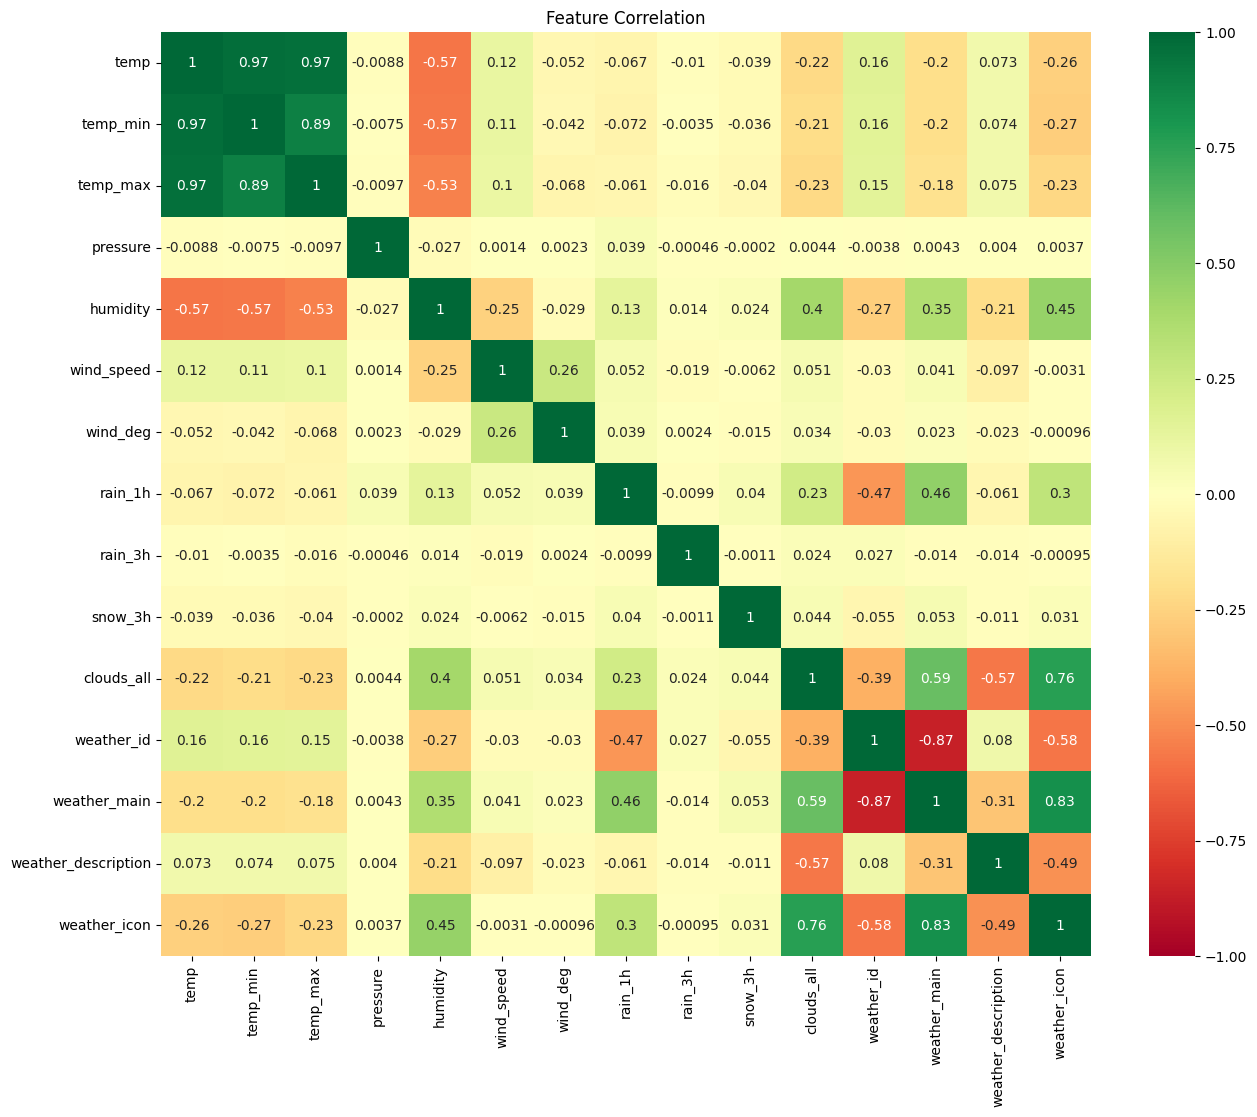

In [64]:
feat_corr(df_temp)

In [65]:
df_weather['weather_id'].unique()

array([800, 801, 802, 803, 804, 500, 501, 502, 701, 522, 521, 503, 202,
       200, 201, 211, 520, 300, 741, 301, 711, 302, 721, 310, 600, 616,
       615, 601, 210, 602, 611, 311, 612, 620, 531, 731, 761, 771])

In [66]:
df_weather.columns

Index(['dt_iso', 'city_name', 'temp', 'temp_min', 'temp_max', 'pressure',
       'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h',
       'clouds_all', 'weather_id', 'weather_main', 'weather_description',
       'weather_icon'],
      dtype='object')

In [67]:
col_drop_name = ['weather_id','weather_main','weather_description','weather_icon', 'temp_min', 'temp_max']
# col_drop_name = ['weather_id', 'weather_main','weather_description','weather_icon']
df_weather.drop(col_drop_name, axis = 1 , inplace = True)

In [68]:
check_Nans_Dups(df_weather)

Number of Nans in each column :
dt_iso        0
city_name     0
temp          0
pressure      0
humidity      0
wind_speed    0
wind_deg      0
rain_1h       0
rain_3h       0
snow_3h       0
clouds_all    0
dtype: int64

Number of duplicates in the dataframe : 3076


In [69]:
df_weather = df_weather.reset_index().drop_duplicates()

In [70]:
df_weather['time'] = pd.to_datetime(df_weather['dt_iso'])
df_weather.drop(["dt_iso"] , axis = 1, inplace = True)
df_weather = df_weather.set_index('time')
df_weather.drop(["index"] , axis = 1, inplace = True)

C:\Users\HARSHIL\AppData\Local\Temp\ipykernel_16300\2996806199.py:1: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_weather['time'] = pd.to_datetime(df_weather['dt_iso'])


In [71]:
df_weather

,city_name,temp,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all
time,,,,,,,,,,
2015-01-01 00:00:00+01:00,Valencia,270.475,1001,77,1,62,0.0,0.0,0.0,0
2015-01-01 01:00:00+01:00,Valencia,270.475,1001,77,1,62,0.0,0.0,0.0,0
2015-01-01 02:00:00+01:00,Valencia,269.686,1002,78,0,23,0.0,0.0,0.0,0
2015-01-01 03:00:00+01:00,Valencia,269.686,1002,78,0,23,0.0,0.0,0.0,0
2015-01-01 04:00:00+01:00,Valencia,269.686,1002,78,0,23,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00+01:00,Seville,287.760,1028,54,3,30,0.0,0.0,0.0,0
2018-12-31 20:00:00+01:00,Seville,285.760,1029,62,3,30,0.0,0.0,0.0,0
2018-12-31 21:00:00+01:00,Seville,285.150,1028,58,4,50,0.0,0.0,0.0,0


In [72]:
df_energy

,generation biomass,generation fossil gas,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load forecast,total load actual,price day ahead,price actual,generation fossil total
time,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+01:00,447.0,4844.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,73.0,49.0,196.0,6378.0,26118.0,25385.0,50.10,65.41,5150.0
2015-01-01 01:00:00+01:00,449.0,5196.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,71.0,50.0,195.0,5890.0,24934.0,24382.0,48.10,64.92,5083.0
2015-01-01 02:00:00+01:00,448.0,4857.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,73.0,50.0,196.0,5461.0,23515.0,22734.0,47.33,64.48,4904.0
2015-01-01 03:00:00+01:00,438.0,4314.0,160.0,1503.0,949.0,779.0,7098.0,43.0,75.0,50.0,191.0,5238.0,22642.0,21286.0,42.27,59.32,4385.0
2015-01-01 04:00:00+01:00,428.0,4130.0,156.0,1826.0,953.0,720.0,7097.0,43.0,74.0,42.0,189.0,4935.0,21785.0,20264.0,38.41,56.04,4027.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00+01:00,297.0,7634.0,178.0,1.0,1135.0,4836.0,6073.0,63.0,95.0,85.0,277.0,3113.0,30619.0,30653.0,68.85,77.02,2628.0
2018-12-31 20:00:00+01:00,296.0,7241.0,174.0,1.0,1172.0,3931.0,6074.0,62.0,95.0,33.0,280.0,3288.0,29932.0,29735.0,68.40,76.16,2566.0
2018-12-31 21:00:00+01:00,292.0,7025.0,168.0,50.0,1148.0,2831.0,6076.0,61.0,94.0,31.0,286.0,3503.0,27903.0,28071.0,66.88,74.30,2422.0


<li> Based on stats below, we can see that there are some outliers in pressure, wind_speed and maybe rain_1h and rain_3h.
So we can see outliers in the plots. we will remove pressure and wind_speed outlier and also drop rain_3h. Becuase
rain_3h is supposed to be the amount of percipitation in the last 3 hr which should be higher than rain_1h, but the plot 
does not confirm this. So we drop rain_3h. </li>

In [73]:
df_weather.describe().round(2)

,temp,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all
count,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00
mean,289.62,1069.26,68.42,2.47,166.59,0.08,0.00,0.00,25.07
std,8.03,5969.63,21.90,2.10,116.61,0.40,0.01,0.22,30.77
min,262.24,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,283.67,1013.00,53.00,1.00,55.00,0.00,0.00,0.00,0.00
50%,289.15,1018.00,72.00,2.00,177.00,0.00,0.00,0.00,20.00
75%,295.15,1022.00,87.00,4.00,270.00,0.00,0.00,0.00,40.00
max,315.60,1008371.00,100.00,133.00,360.00,12.00,2.32,21.50,100.00


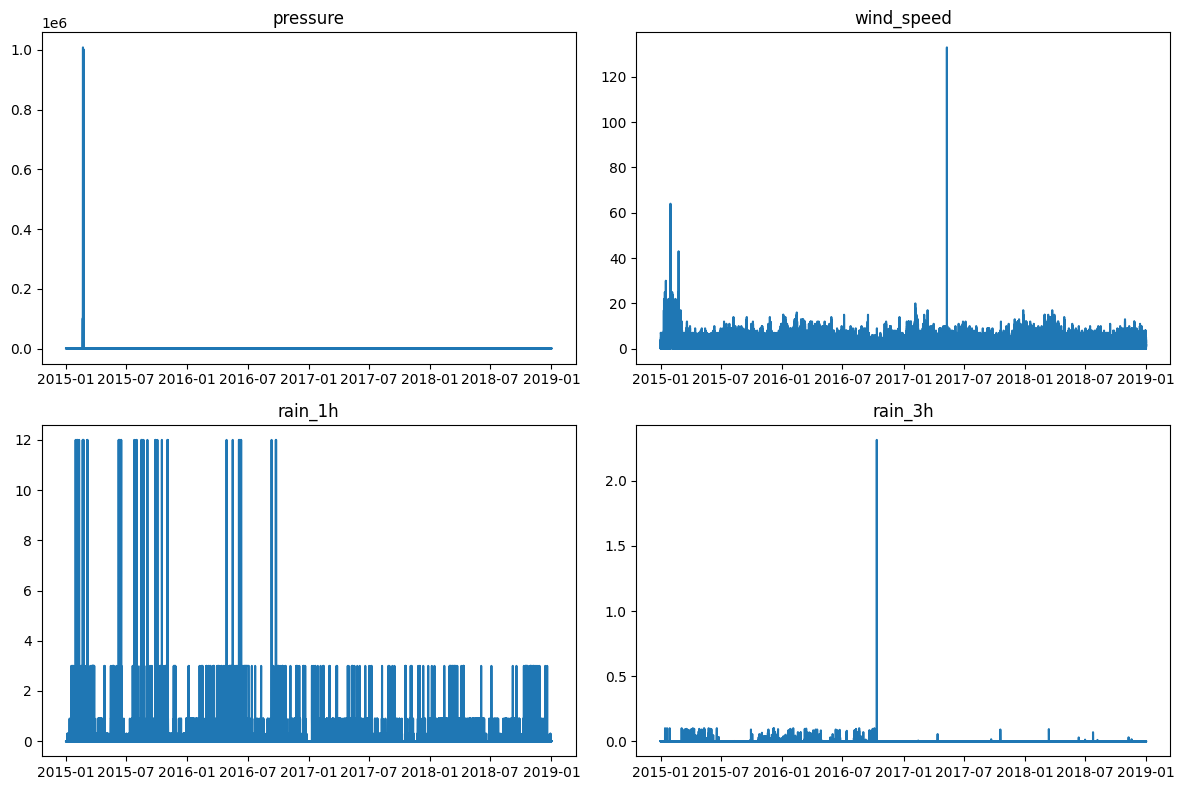

In [74]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

# select the columns to plot
columns_to_plot = ['pressure', 'wind_speed', 'rain_1h', 'rain_3h']

# loop through the subplots and plot each column
for i, ax in enumerate(axes.flat):
    if i < len(columns_to_plot):
        ax.plot(df_weather.index, df_weather[columns_to_plot[i]])
        ax.set_title(columns_to_plot[i])
    else:
        ax.set_visible(False)

plt.tight_layout()  # adjust the spacing between subplots
plt.show()  # display the plot

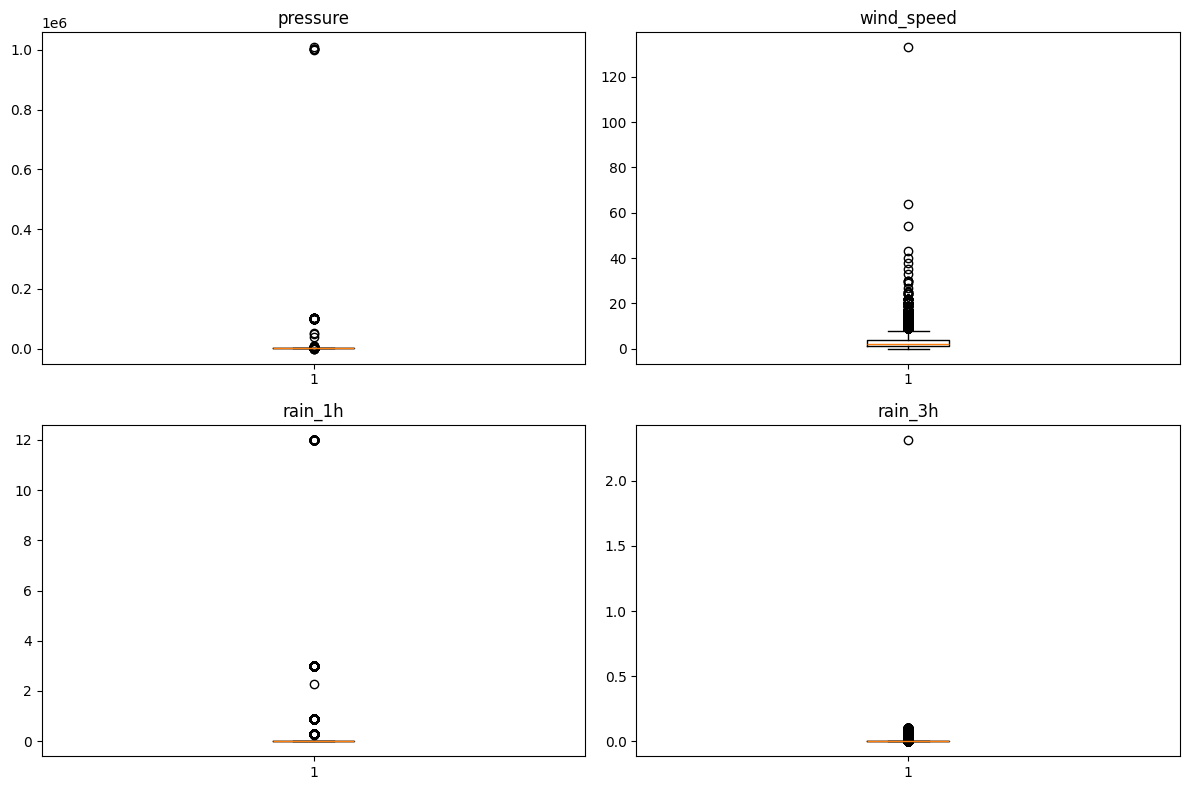

In [75]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

# select the columns to plot
columns_to_plot = ['pressure', 'wind_speed', 'rain_1h', 'rain_3h']

# loop through the subplots and plot each column
for i, ax in enumerate(axes.flat):
    if i < len(columns_to_plot):
        ax.boxplot(x = df_weather[columns_to_plot[i]])
        ax.set_title(columns_to_plot[i])
    else:
        ax.set_visible(False)

plt.tight_layout()  # adjust the spacing between subplots
plt.show()  # display the plot

<strong> Note: </strong>
<p>
</p>
<li> Maximum pressure on earth is recorded as 1080hPa : 
<a href="https://wmo.asu.edu/content/world-highest-sea-level-air-pressure-below-700m">https://wmo.asu.edu/content/world-highest-sea-level-air-pressure-below-700m</a>
<li> Minimum pressure on earth is recorded as 870hPa : 
<a href="https://wmo.asu.edu/content/world-lowest-sea-level-air-pressure-excluding-tornadoes">https://wmo.asu.edu/content/world-lowest-sea-level-air-pressure-excluding-tornadoes</a>
    
<li> Maximum wind speed on earth is recorded as 113 m/s : <a href="https://www.wunderground.com/cat6/the-highest-anemometer-measured-wind-speeds-on-earth">https://www.wunderground.com/cat6/the-highest-anemometer-measured-wind-speeds-on-earth</a>
<p>
</p>
<li> So we set the max threshold as these numbers and replace the outliers with Nan values and then use interpolation to fill the gap. </li>        

In [76]:
df_weather.loc[df_weather['pressure']  > 1080,  'pressure'] = np.nan
df_weather.loc[df_weather['pressure']   < 870,  'pressure'] = np.nan
df_weather.loc[df_weather['wind_speed'] > 113, 'wind_speed'] = np.nan

df_weather.interpolate(method ='linear', limit_direction ='forward', inplace = True)

C:\Users\HARSHIL\AppData\Local\Temp\ipykernel_16300\42852904.py:5: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_weather.interpolate(method ='linear', limit_direction ='forward', inplace = True)


<li> Check if the outliers are removed! </li>

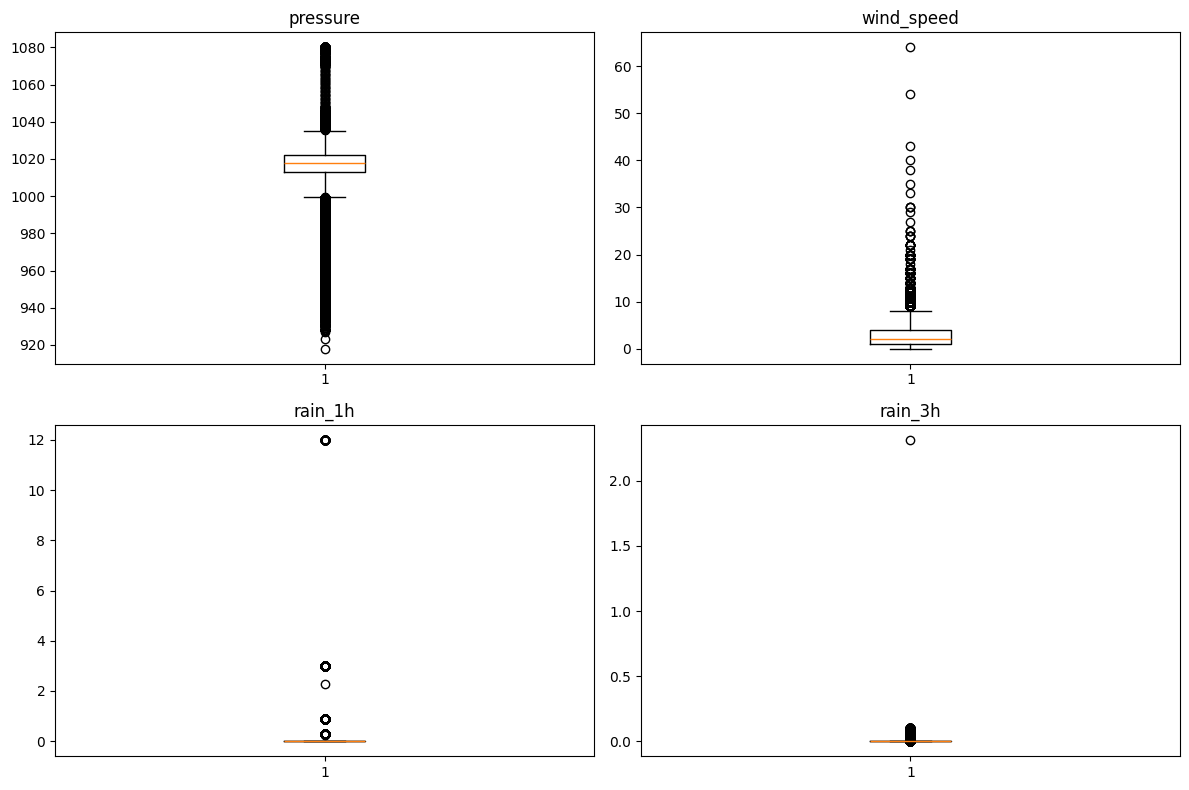

In [77]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

# select the columns to plot
columns_to_plot = ['pressure', 'wind_speed', 'rain_1h', 'rain_3h']

# loop through the subplots and plot each column
for i, ax in enumerate(axes.flat):
    if i < len(columns_to_plot):
        ax.boxplot(x = df_weather[columns_to_plot[i]])
        ax.set_title(columns_to_plot[i])
    else:
        ax.set_visible(False)

plt.tight_layout()  # adjust the spacing between subplots
plt.show()  # display the plot

In [78]:
# be sure to drop rain_h3
df_weather.drop(['rain_3h'], axis = 1 , inplace = True)

<li> So number of samples in each group of city is not consistent! probably it has duplicates!</li>

In [80]:
print(f'Number of samples in df_energy is {df_energy.shape[0]}')

city_list = df_weather['city_name'].unique()
grouped_weather = df_weather.groupby('city_name')

for city in city_list:
    print(f'Number of samples in df_weather in {city} is {grouped_weather.get_group(city).shape[0]}')

Number of samples in df_energy is 35064
Number of samples in df_weather in Valencia is 35145
Number of samples in df_weather in Madrid is 36267
Number of samples in df_weather in Bilbao is 35951
Number of samples in df_weather in  Barcelona is 35476
Number of samples in df_weather in Seville is 35557


In [81]:
df_weather_cleaned = df_weather.reset_index().drop_duplicates(subset=['time', 'city_name'], keep='first').set_index('time')

In [82]:
df_weather_cleaned

,city_name,temp,pressure,humidity,wind_speed,wind_deg,rain_1h,snow_3h,clouds_all
time,,,,,,,,,
2015-01-01 00:00:00+01:00,Valencia,270.475,1001.0,77,1.0,62,0.0,0.0,0
2015-01-01 01:00:00+01:00,Valencia,270.475,1001.0,77,1.0,62,0.0,0.0,0
2015-01-01 02:00:00+01:00,Valencia,269.686,1002.0,78,0.0,23,0.0,0.0,0
2015-01-01 03:00:00+01:00,Valencia,269.686,1002.0,78,0.0,23,0.0,0.0,0
2015-01-01 04:00:00+01:00,Valencia,269.686,1002.0,78,0.0,23,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00+01:00,Seville,287.760,1028.0,54,3.0,30,0.0,0.0,0
2018-12-31 20:00:00+01:00,Seville,285.760,1029.0,62,3.0,30,0.0,0.0,0
2018-12-31 21:00:00+01:00,Seville,285.150,1028.0,58,4.0,50,0.0,0.0,0


<li> Now the number of samples in each group is the same! So we can concat weather dataframe with energy dataframe.</li>

In [83]:
print(f'Number of samples in df_energy is {df_energy.shape[0]}')

city_list = df_weather['city_name'].unique()
grouped_weather = df_weather_cleaned.groupby('city_name')

for city in city_list:
    print(f'Number of samples in df_weather in {city} is {grouped_weather.get_group(city).shape[0]}')

Number of samples in df_energy is 35064
Number of samples in df_weather in Valencia is 35064
Number of samples in df_weather in Madrid is 35064
Number of samples in df_weather in Bilbao is 35064
Number of samples in df_weather in  Barcelona is 35064
Number of samples in df_weather in Seville is 35064


In [84]:
df_weather_all_cities = [grouped_weather.get_group(x) for x in grouped_weather.groups]

In [162]:
df_weather_all_cities[0]

,city_name,temp,pressure,humidity,wind_speed,wind_deg,rain_1h,snow_3h,clouds_all
time,,,,,,,,,
2015-01-01 00:00:00+01:00,Barcelona,281.625,1035.0,100,7.0,58,0.0,0.0,0
2015-01-01 01:00:00+01:00,Barcelona,281.625,1035.0,100,7.0,58,0.0,0.0,0
2015-01-01 02:00:00+01:00,Barcelona,281.286,1036.0,100,7.0,48,0.0,0.0,0
2015-01-01 03:00:00+01:00,Barcelona,281.286,1036.0,100,7.0,48,0.0,0.0,0
2015-01-01 04:00:00+01:00,Barcelona,281.286,1036.0,100,7.0,48,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00+01:00,Barcelona,284.130,1027.0,71,1.0,250,0.0,0.0,0
2018-12-31 20:00:00+01:00,Barcelona,282.640,1027.0,62,3.0,270,0.0,0.0,0
2018-12-31 21:00:00+01:00,Barcelona,282.140,1028.0,53,4.0,300,0.0,0.0,0


In [86]:
df_weather_energy = df_energy

for df_city in df_weather_all_cities:
    city_name = df_city.iloc[0]['city_name'].replace(' ', '')
    df_temp_city = df_city.add_suffix(f'_{city_name}')
    df_weather_energy = pd.concat([df_weather_energy, df_temp_city], axis=1)
    df_weather_energy = df_weather_energy.drop(f'city_name_{city_name}' , axis=1)

In [87]:
df_weather_energy.columns

Index(['generation biomass', 'generation fossil gas', 'generation fossil oil',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load forecast',
       'total load actual', 'price day ahead', 'price actual',
       'generation fossil total', 'temp_Barcelona', 'pressure_Barcelona',
       'humidity_Barcelona', 'wind_speed_Barcelona', 'wind_deg_Barcelona',
       'rain_1h_Barcelona', 'snow_3h_Barcelona', 'clouds_all_Barcelona',
       'temp_Bilbao', 'pressure_Bilbao', 'humidity_Bilbao',
       'wind_speed_Bilbao', 'wind_deg_Bilbao', 'rain_1h_Bilbao',
       'snow_3h_Bilbao', 'clouds_all_Bilbao', 'temp_Madrid', 'pressure_Madrid',
       'humidity_Madrid', 'wind_speed_Madrid', 'wind_deg_Madrid',
       'rain_1h_Madrid', 'snow_3h_Madri

<li> So far, so good! There is no duplicates and Nans in df_weather_energy! </li>

In [88]:
check_Nans_Dups(df_weather_energy)

Number of Nans in each column :
generation biomass                             0
generation fossil gas                          0
generation fossil oil                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation nuclear                             0
generation other                               0
generation other renewable                     0
generation solar                               0
generation waste                               0
generation wind onshore                        0
total load forecast                            0
total load actual                              0
price day ahead                                0
price actual                                   0
generation fossil total                        0
temp_Barcelona                                 0
pressure_Barcelona                             0
humidity_Barcelona                   

<li>There are some powerful feature engineering techniques for time series that can boost the model perfroamnce:

<a href="https://www.analyticsvidhya.com/blog/2019/12/6-powerful-feature-engineering-techniques-time-series/">https://www.analyticsvidhya.com/blog/2019/12/6-powerful-feature-engineering-techniques-time-series/</a>
<p>
</p>
<li> For now, we are adding <strong>hour, weekday and month</strong> features to dataframe. These information can be helpful. For example in 
shoulder seasons the heating and cooling load of all residential and commercial buildings will be low compared to summer/winter. or at the 
weekend, since the office buildings are closed, the energy consumption will be lower.Regading the time, defintily energy consumption at 3 am 
is way lower than the energy consumption at 10 am. So these features can be very helpful in building a good model.</li>
<p>
</p>

In [89]:
df_weather_energy['hour'] = df_weather_energy.index.map(lambda x : x.hour)
df_weather_energy['weekday'] = df_weather_energy.index.map(lambda x : x.weekday())
df_weather_energy['month'] = df_weather_energy.index.map(lambda x : x.month)
df_weather_energy['year'] = df_weather_energy.index.map(lambda x: x.year)

In [90]:
df_weather_energy.columns

Index(['generation biomass', 'generation fossil gas', 'generation fossil oil',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load forecast',
       'total load actual', 'price day ahead', 'price actual',
       'generation fossil total', 'temp_Barcelona', 'pressure_Barcelona',
       'humidity_Barcelona', 'wind_speed_Barcelona', 'wind_deg_Barcelona',
       'rain_1h_Barcelona', 'snow_3h_Barcelona', 'clouds_all_Barcelona',
       'temp_Bilbao', 'pressure_Bilbao', 'humidity_Bilbao',
       'wind_speed_Bilbao', 'wind_deg_Bilbao', 'rain_1h_Bilbao',
       'snow_3h_Bilbao', 'clouds_all_Bilbao', 'temp_Madrid', 'pressure_Madrid',
       'humidity_Madrid', 'wind_speed_Madrid', 'wind_deg_Madrid',
       'rain_1h_Madrid', 'snow_3h_Madri

<h3> Visualization </h3>

<li> Based on the month bar plot, the actual price in Jan and Dec is high and on weekly daily basis, 
we witness the lowest price at weekends. </li>

Text(0.5, 1.0, 'Daily actual price (0 is Monday)')

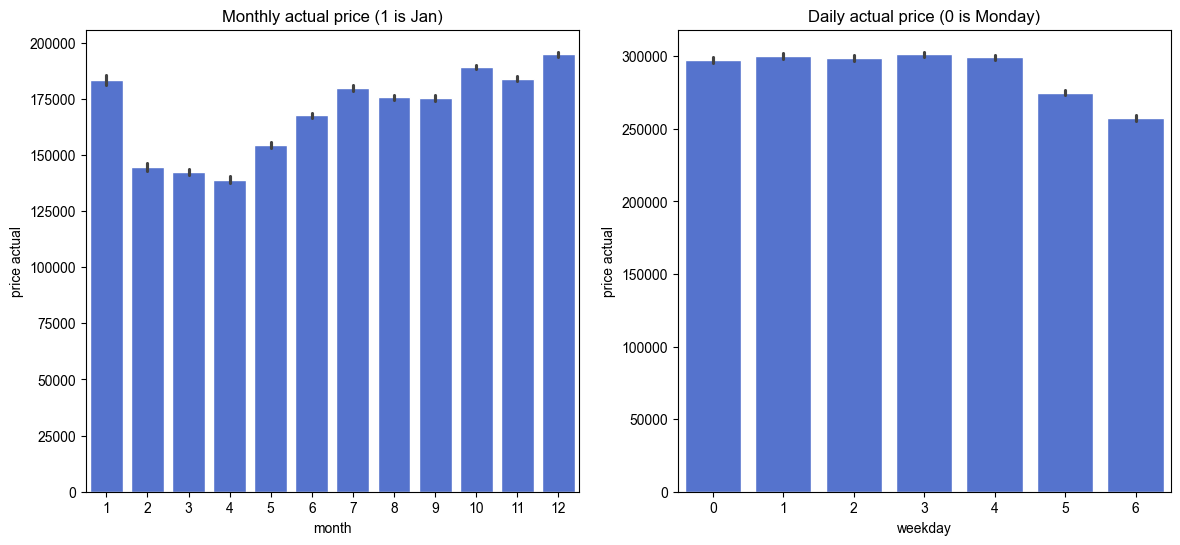

In [92]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))
sns.set(style="darkgrid")

sns.barplot(
    x="month", 
    y="price actual", 
    data=df_weather_energy, 
    estimator=sum, 
    color='royalblue',
    ax=axes[0]);
axes[0].set_title('Monthly actual price (1 is Jan)')

sns.barplot(
    x="weekday", 
    y="price actual", 
    data=df_weather_energy, 
    estimator=sum, 
    color='royalblue',
    ax=axes[1]);
axes[1].set_title('Daily actual price (0 is Monday)')


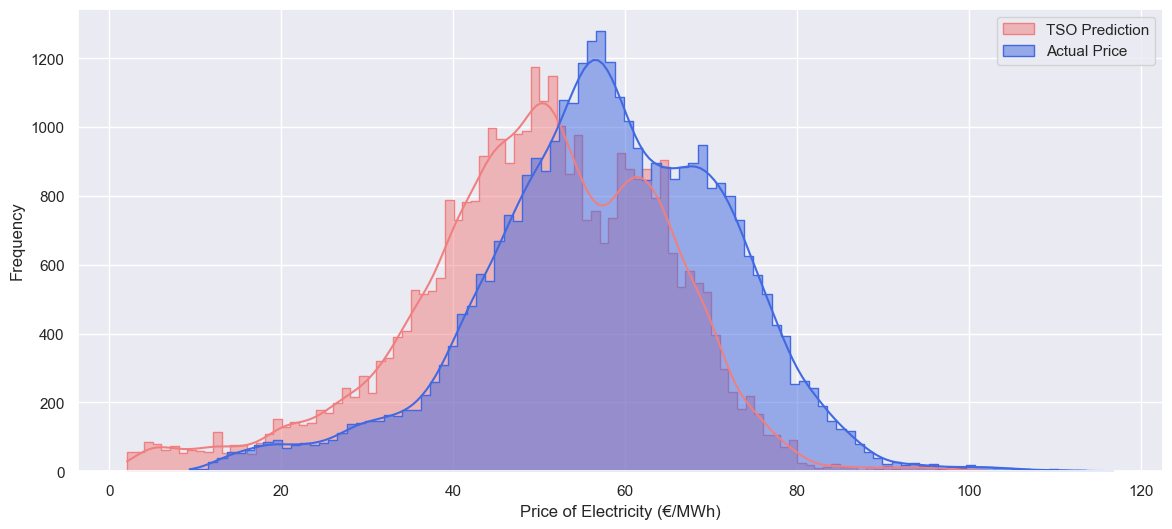

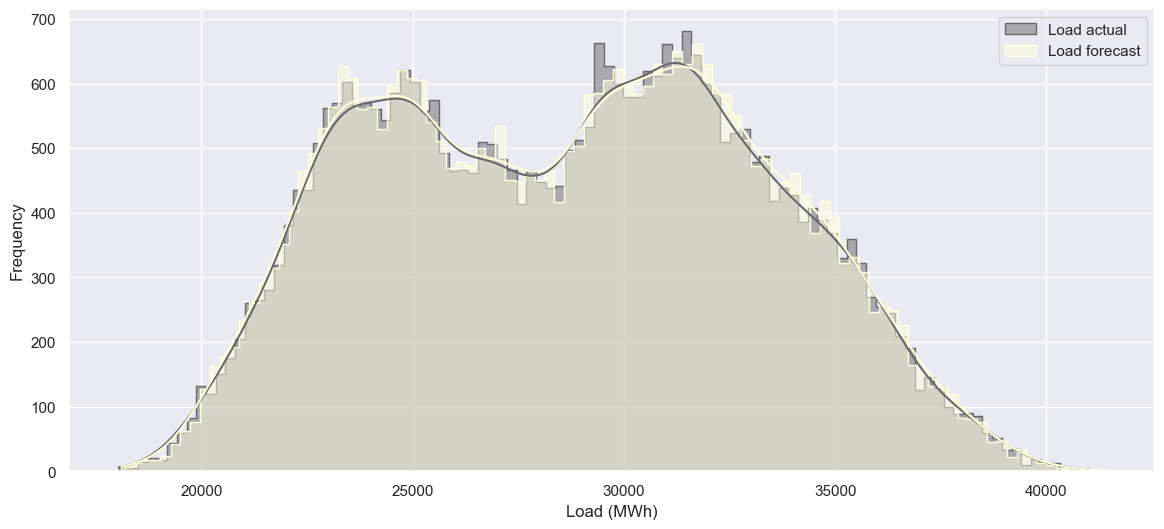

In [93]:
plt.figure(figsize=(14,6))

gr = sns.histplot(df_weather_energy['price day ahead'], bins=100, label='TSO Prediction', element="step", color='lightcoral', kde = True)
gr = sns.histplot(df_weather_energy['price actual'], bins=100, label='Actual Price', element="step", color='royalblue', kde = True)


gr.set(xlabel="Price of Electricity (€/MWh)", ylabel="Frequency")
plt.legend()
plt.show()

plt.figure(figsize=(14,6))
gr = sns.histplot(df_weather_energy['total load actual'], bins=100, label='Load actual', element="step", color='dimgrey', kde = True)
gr = sns.histplot(df_weather_energy['total load forecast'], bins=100, label='Load forecast', element="step", color='lightyellow', kde = True)

gr.set(xlabel="Load (MWh)", ylabel="Frequency")
plt.legend()
plt.show()

<li> I tried to estimate the mean absolute error for <strong> normalized </strong> acutal price and TSO predcition (price day ahead) on the test set.
I tried to normalized the data because I used normalized data for training part, so the comparision would be easy.
Later you will find I considered that last 10 % of the data as test set! so <strong> int(0.9*df_weather_energy.shape[0]) 
</strong> represents the begining index of the test size. So the MAE for TSO prediction for the test size is <strong> 0.07 </strong> </li> 

In [94]:
y_scaler_actual = MinMaxScaler()
y_scaler_dayahead = MinMaxScaler()

train_cutoff = int(0.8*df_weather_energy.shape[0])
val_cutoff = int(0.9*df_weather_energy.shape[0])

y_price_actual   = df_weather_energy[['price actual']]
y_price_dayahead = df_weather_energy[['price day ahead']]

y_scaler_actual.fit(y_price_actual[:train_cutoff])
actual_norm = y_scaler_actual.transform(y_price_actual)

y_scaler_dayahead.fit(df_weather_energy[['price day ahead']][:train_cutoff])
dayahead_norm = y_scaler_dayahead.transform(y_price_dayahead)

print(f' mean absolute error for normalized acutal price and TSO predcition is : {round(mean_absolute_error(actual_norm, dayahead_norm),3)}')

 mean absolute error for normalized acutal price and TSO predcition is : 0.071


<li> As I already explained above, we need to drop <strong> total load forecast</strong> from the data! </li>

In [95]:
df_weather_energy.drop(['total load forecast'], axis = 1, inplace = True)

<li> So I decompose the price actual into trend, seasonality and residual(noise). for better visualization, 
I ploted 100 first observed seasonality and call it as zoomed seasonality.</li>

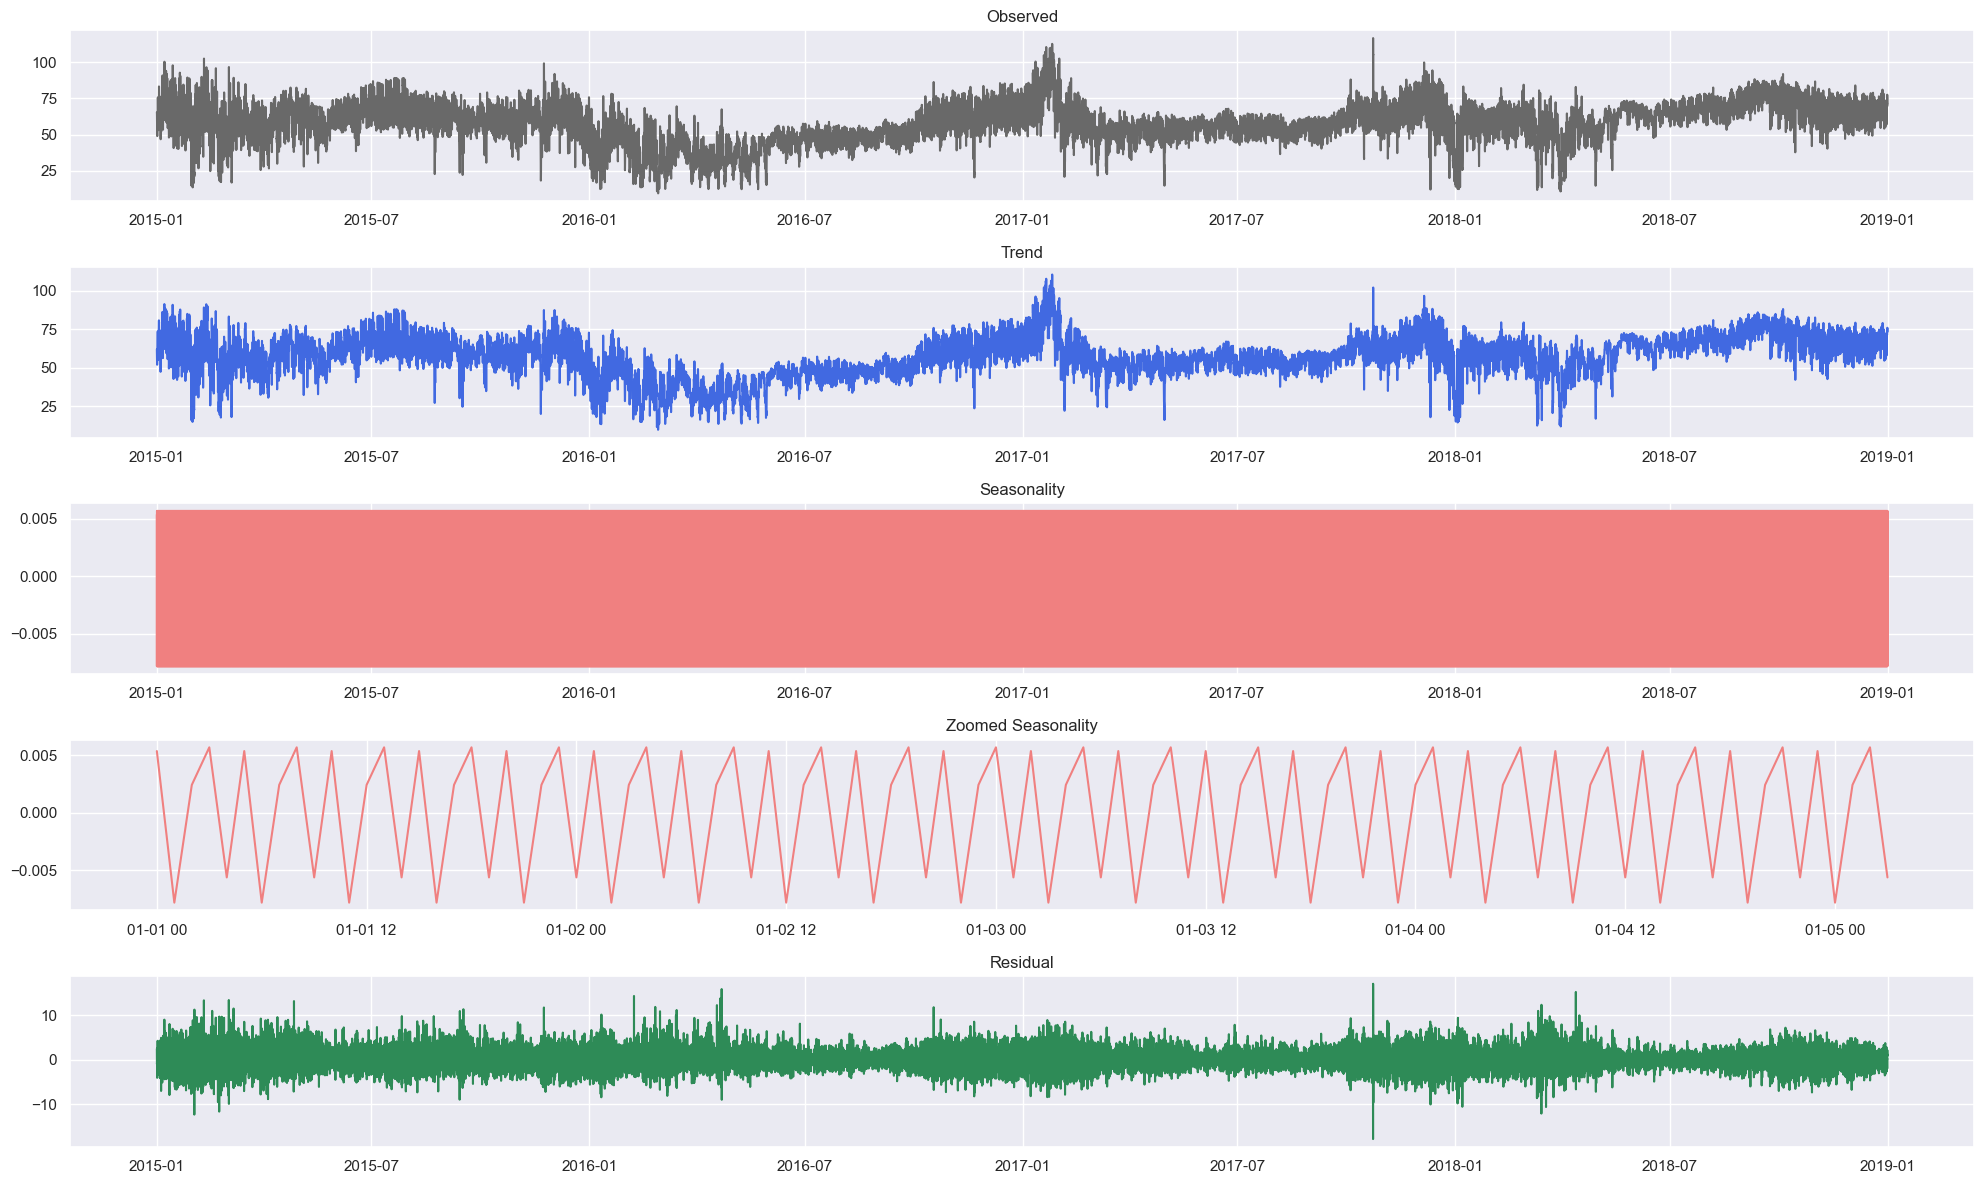

In [96]:
fig, axes = plt.subplots(5, 1, figsize=(20, 12))
decom_data = df_weather_energy[['price actual']].copy()

decompose_result = seasonal_decompose(decom_data, period =5, model='additive')

observed    = decompose_result.observed
trend    = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

axes[0].plot(observed, color='dimgrey')
axes[0].set_title('Observed')
axes[1].plot(trend, color='royalblue')
axes[1].set_title('Trend')
axes[2].plot(seasonal, color='lightcoral')
axes[2].set_title('Seasonality')
axes[3].plot(seasonal[:100], color='lightcoral')
axes[3].set_title('Zoomed Seasonality')
axes[4].plot(residual, color='seagreen')
axes[4].set_title('Residual')

fig.tight_layout()
plt.show()


<li> <strong> The Dickey-Fuller test </strong>, also known as the Augmented Dickey-Fuller (ADF) test, is a statistical test used to 
determine whether a time series is <strong> stationary </strong> or not. Stationarity is an important concept in time series analysis
because it affects the ability to model and predict future values. The test uses a null hypothesis that the time 
series has a unit root, meaning that it is non-stationary. The alternative hypothesis is that the time series 
is stationary. The test statistic is compared to critical values from tables or computed via a statistical 
software package. If the test statistic is less than the critical value, the null hypothesis is rejected, 
and it is concluded that the time series is stationary.</li>
<p>
</p>
<li> In the context of time series analysis, stationarity refers to a property of a time series where the 
statistical properties of the series <strong> do not change over time </strong>. More specifically, a stationary time series is 
one where <strong> the mean, variance, and autocorrelation </strong> structure of the series do not depend on the time at which 
they are computed.</li>
<p>
</p>
<li>The concept of stationarity is important in time series analysis because it simplifies the modeling process and 
enables the use of statistical tools that assume stationarity, such as  <strong>ARMA</strong> (autoregressive moving average) models.
In contrast, non-stationary time series can exhibit trends, seasonality, and other systematic patterns that can 
make it difficult to model and forecast accurately.</li>


In [97]:
result = adfuller(df_weather_energy[['price actual']])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -9.147016232851168
p-value: 2.750493484934598e-15
Critical Values: {'1%': np.float64(-3.4305367814665044), '5%': np.float64(-2.8616225527935106), '10%': np.float64(-2.566813940257257)}


<li> So based on the comments above we can see that the ADF statistics is even lower than the p value with 1% 
significance level. So the time series is considered as stationary! </li>

<li> <strong>Autocorrelation</strong> is a measure of the linear dependence between a time series and its lagged values. It measures 
how strongly the values of a time series at one time are correlated with the values at other times. Autocorrelation 
can be positive (indicating that high values tend to be followed by high values and low values tend to be followed 
by low values) or negative (indicating that high values tend to be followed by low values and vice versa). </li>
<p>
</p>
<li> <strong>Partial autocorrelation</strong>, on the other hand, measures the linear dependence between a time series and its lagged 
values, <strong> after removing the effect of any intermediate lags </strong>. It provides a measure of the direct correlation between 
two time points, taking into account any indirect correlation through intermediate time points. Partial autocorrelation 
can help identify the <strong> order </strong> of an autoregressive (AR) model, which is a model that uses lagged values of the time series 
as predictors. </li>

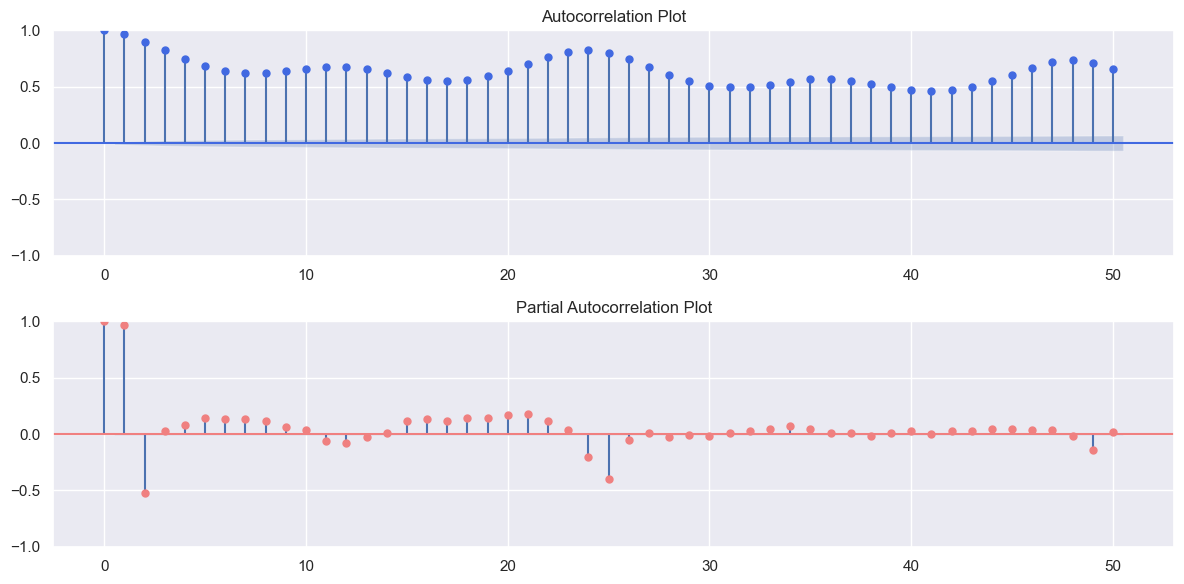

In [98]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(df_weather_energy['price actual'], lags=50, ax=ax[0], color='royalblue')
ax[0].set_title('Autocorrelation Plot')
plot_pacf(df_weather_energy['price actual'], lags=50, ax=ax[1], color='lightcoral')
ax[1].set_title('Partial Autocorrelation Plot')
plt.tight_layout()
plt.show()

<li> Based on the partial autocorrolation, we have strong correlation of an observation with its past 25 values (after 25,
the correlation becomes very weak). So we use <strong> 25 </strong> lag feature for our time series! </li>

<h3> Dimensionality reduction and train-test split </h3>
<p>
</p>
<li> In this section I applied PCA for dimensionality reduction and add windowing to the dataset to make it prepared as input for tensorflow. I also split the train, validation and test sets and plot it with seperate colors in the figure. 
For faster convergnce and better performance of ML/DL models I normalzed the dataset. </li>

In [160]:
X = df_weather_energy.drop(['price actual'], axis = 1)
y= df_weather_energy[['price actual']]


In [161]:
X.columns

Index(['generation biomass', 'generation fossil gas', 'generation fossil oil',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load actual',
       'price day ahead', 'generation fossil total', 'temp_Barcelona',
       'pressure_Barcelona', 'humidity_Barcelona', 'wind_speed_Barcelona',
       'wind_deg_Barcelona', 'rain_1h_Barcelona', 'snow_3h_Barcelona',
       'clouds_all_Barcelona', 'temp_Bilbao', 'pressure_Bilbao',
       'humidity_Bilbao', 'wind_speed_Bilbao', 'wind_deg_Bilbao',
       'rain_1h_Bilbao', 'snow_3h_Bilbao', 'clouds_all_Bilbao', 'temp_Madrid',
       'pressure_Madrid', 'humidity_Madrid', 'wind_speed_Madrid',
       'wind_deg_Madrid', 'rain_1h_Madrid', 'snow_3h_Madrid',
       'clouds_all_Madrid', 'temp_Seville'

In [157]:
# Corrected code
def apply_PCA(X_input, cum_variance, if_apply):
    if if_apply:
        pca = PCA(n_components=cum_variance)
        # Create just ONE pipeline
        scaler_pca_pipeline = make_pipeline(MinMaxScaler(), pca)

        # FIT and TRANSFORM using that same pipeline
        X_pca = scaler_pca_pipeline.fit(X_input).transform(X_input)

        # Now, SAVE the pipeline that was just fitted
        joblib.dump(scaler_pca_pipeline, 'scaler_pca.pkl')
        print("✅ 'scaler_pca.pkl' saved successfully!")

        return X_pca
    else:
        return np.array(X_input)

In [158]:
params_pca = {'cum_variance' : 0.8, 'if_apply' : True }
X_pca = apply_PCA(X, **params_pca)
X_pca.shape

✅ 'scaler_pca.pkl' saved successfully!


(35064, 15)

In [165]:
import pandas as pd
import numpy as np
import joblib
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from datetime import datetime, timedelta

# --- MOCK DATABASE AND API FUNCTIONS ---
# In a real application, these functions would connect to a real database or APIs.
def fetch_data_from_database(start_time, end_time, table_name, city=None):
    """
    This is a MOCK function to simulate fetching data.
    Replace this with your actual database query logic.
    """
    print(f"  -> Mock fetching '{table_name}' data for '{city or 'all cities'}' from {start_time} to {end_time}...")
    
    # Simulate fetching weather data for one city
    if "weather" in table_name and city:
        weather_columns = ['temp', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'snow_3h', 'clouds_all', 'city_name']
        data = np.random.rand(24, len(weather_columns) - 1)
        df = pd.DataFrame(data, columns=weather_columns[:-1])
        df['city_name'] = city
        return df

    # Simulate fetching energy data
    elif "energy" in table_name:
        energy_columns = [
            'generation biomass', 'generation fossil gas', 'generation fossil oil',
            'generation hydro pumped storage consumption', 'generation hydro run-of-river and poundage',
            'generation hydro water reservoir', 'generation nuclear', 'generation other',
            'generation other renewable', 'generation solar', 'generation waste', 'generation wind onshore',
            'total load actual', 'price day ahead', 'generation fossil total', 'price actual'
        ]
        # We add extra columns for date features that will be created later
        num_cols = len(energy_columns)
        df = pd.DataFrame(np.random.rand(24, num_cols), columns=energy_columns)
        # Add a mock price actual for the raw_price_24hr input
        df['price actual'] = np.random.rand(24, 1) * 60 + 10
        return df
    return pd.DataFrame()


# --- LEVEL 1: The Core Prediction Engine (No changes here) ---
def predict_next_hour_price(raw_features_24hr, raw_price_24hr):
    """
    (Low-level engine) Predicts price from fully prepared dataframes.
    """
    try:
        scaler_pca = joblib.load('scaler_pca.pkl')
        scaler_y = joblib.load('scaler_y.pkl')
        xgb_model = joblib.load('xgb_regressor.pkl')
    except FileNotFoundError as e:
        print(f"❌ Error loading model files: {e}")
        return None

    features_pca = scaler_pca.transform(raw_features_24hr)
    price_scaled = scaler_y.transform(raw_price_24hr)
    prediction_window = np.concatenate((features_pca, price_scaled), axis=1)
    xgb_input = prediction_window.reshape(1, -1)
    scaled_prediction = xgb_model.predict(xgb_input)
    final_prediction = scaler_y.inverse_transform(scaled_prediction.reshape(1, -1))
    return final_prediction[0, 0]


# --- LEVEL 2: The User-Facing Function (This is the new part) ---
def get_prediction_for(target_time_str, cities):
    """
    (High-level interface) Fetches, assembles, and predicts for a given time.
    This is the function your application's frontend should call.

    Args:
        target_time_str (str): The time for which you want a forecast (e.g., "2025-10-26 15:00:00").
        cities (list): A list of all cities required by the model.

    Returns:
        float: The predicted electricity price, or None if an error occurs.
    """
    print(f"\n🚀 Starting prediction process for target time: {target_time_str}")
    
    # 1. Calculate the 24-hour historical window needed for the prediction
    target_time = pd.to_datetime(target_time_str)
    end_time = target_time - timedelta(hours=1)
    start_time = target_time - timedelta(hours=24)

    # 2. --- DATA GATHERING AND ASSEMBLY ---
    # This section simulates the automated data pipeline.
    print("Step 1: Fetching raw data from sources...")
    df_energy = fetch_data_from_database(start_time, end_time, "energy_data")
    
    df_weather_all_cities = []
    for city in cities:
        df_city_weather = fetch_data_from_database(start_time, end_time, "weather_data", city=city)
        df_weather_all_cities.append(df_city_weather)

    # 3. --- DATA MERGING (Replicating your notebook logic) ---
    print("Step 2: Assembling the final feature dataframe...")
    df_weather_energy = df_energy.copy()
    for df_city in df_weather_all_cities:
        city_name = df_city.iloc[0]['city_name']
        df_temp_city = df_city.add_suffix(f'_{city_name}')
        df_weather_energy = pd.concat([df_weather_energy, df_temp_city], axis=1)
        df_weather_energy = df_weather_energy.drop(f'city_name_{city_name}', axis=1)

    # 4. --- FINAL INPUT PREPARATION ---
    print("Step 3: Preparing inputs for the prediction engine...")
    
    # Create date features, which the model expects
    df_weather_energy['hour'] = pd.to_datetime(df_weather_energy.index).hour
    df_weather_energy['weekday'] = pd.to_datetime(df_weather_energy.index).weekday
    df_weather_energy['month'] = pd.to_datetime(df_weather_energy.index).month
    df_weather_energy['year'] = pd.to_datetime(df_weather_energy.index).year
    
    # Isolate the target variable (price)
    raw_price_24hr = df_weather_energy[['price actual']]

    # Isolate the features by dropping the target
    # Ensure the column order matches the training data
    original_feature_columns = joblib.load('scaler_pca.pkl').steps[0][1].feature_names_in_
    raw_features_24hr = df_weather_energy.drop('price actual', axis=1)
    raw_features_24hr = raw_features_24hr[original_feature_columns] # Enforce order

    # 5. --- CALL THE PREDICTION ENGINE ---
    print("Step 4: Calling the core prediction engine...")
    predicted_price = predict_next_hour_price(raw_features_24hr, raw_price_24hr)

    return predicted_price


# --- Example Usage ---
if __name__ == "__main__":
    
    # Define the cities your model was trained on
    ALL_CITIES = ['Barcelona', 'Bilbao', 'Madrid', 'Seville', 'Valencia']
    
    # The only input the user (or frontend) provides is the time they want a forecast for.
    prediction_time = "2025-10-26 15:00:00"
    
    # Call the new, simplified function
    predicted_price = get_prediction_for(prediction_time, ALL_CITIES)

    if predicted_price is not None:
        print("\n-----------------------------------------")
        print(f"📈 Predicted Price for {prediction_time}: {predicted_price:.2f}")
        print("-----------------------------------------")




🚀 Starting prediction process for target time: 2025-10-26 15:00:00
Step 1: Fetching raw data from sources...
  -> Mock fetching 'energy_data' data for 'all cities' from 2025-10-25 15:00:00 to 2025-10-26 14:00:00...
  -> Mock fetching 'weather_data' data for 'Barcelona' from 2025-10-25 15:00:00 to 2025-10-26 14:00:00...
  -> Mock fetching 'weather_data' data for 'Bilbao' from 2025-10-25 15:00:00 to 2025-10-26 14:00:00...
  -> Mock fetching 'weather_data' data for 'Madrid' from 2025-10-25 15:00:00 to 2025-10-26 14:00:00...
  -> Mock fetching 'weather_data' data for 'Seville' from 2025-10-25 15:00:00 to 2025-10-26 14:00:00...
  -> Mock fetching 'weather_data' data for 'Valencia' from 2025-10-25 15:00:00 to 2025-10-26 14:00:00...
Step 2: Assembling the final feature dataframe...
Step 3: Preparing inputs for the prediction engine...
Step 4: Calling the core prediction engine...

-----------------------------------------
📈 Predicted Price for 2025-10-26 15:00:00: 66.83
---------------------

In [170]:
df_weather_energy.columns

Index(['generation biomass', 'generation fossil gas', 'generation fossil oil',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load actual',
       'price day ahead', 'price actual', 'generation fossil total',
       'temp_Barcelona', 'pressure_Barcelona', 'humidity_Barcelona',
       'wind_speed_Barcelona', 'wind_deg_Barcelona', 'rain_1h_Barcelona',
       'snow_3h_Barcelona', 'clouds_all_Barcelona', 'temp_Bilbao',
       'pressure_Bilbao', 'humidity_Bilbao', 'wind_speed_Bilbao',
       'wind_deg_Bilbao', 'rain_1h_Bilbao', 'snow_3h_Bilbao',
       'clouds_all_Bilbao', 'temp_Madrid', 'pressure_Madrid',
       'humidity_Madrid', 'wind_speed_Madrid', 'wind_deg_Madrid',
       'rain_1h_Madrid', 'snow_3h_Madrid', 'clouds_all_Madrid'

In [169]:
import pandas as pd
import numpy as np
import joblib
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from datetime import datetime, timedelta

# --- DATA FETCHING FROM CSV FILES ---
# This function now reads directly from your CSV files.
def fetch_data_from_csvs(start_time, end_time, energy_csv_path, weather_csv_path, city=None):
    """
    This function loads data from CSVs, filters it for the required time window,
    and returns it as a DataFrame.
    """
    try:
        # Load the entire CSVs. It's efficient enough for testing.
        # Ensure your CSVs have a 'time' column that can be parsed as a date.
        if "energy" in energy_csv_path:
            df = pd.read_csv(energy_csv_path, parse_dates=['time'], index_col='time')
            # Filter the dataframe for the specific 24-hour window
            filtered_df = df.loc[start_time:end_time]
            return filtered_df

        elif "weather" in weather_csv_path:
            df = pd.read_csv(weather_csv_path, parse_dates=['time'], index_col='time')
            # Filter by city first, then by the time window
            if city:
                city_df = df[df['city_name'] == city]
                filtered_df = city_df.loc[start_time:end_time]
                return filtered_df

    except FileNotFoundError as e:
        print(f"  -> ❌ File Not Found Error: {e}")
        return pd.DataFrame()
    except Exception as e:
        print(f"  -> ❌ An error occurred while reading CSVs: {e}")
        return pd.DataFrame()

    return pd.DataFrame()


# --- LEVEL 1: The Core Prediction Engine (No changes here) ---
def predict_next_hour_price(raw_features_24hr, raw_price_24hr):
    """
    (Low-level engine) Predicts price from fully prepared dataframes.
    """
    try:
        scaler_pca = joblib.load('scaler_pca.pkl')
        scaler_y = joblib.load('scaler_y.pkl')
        xgb_model = joblib.load('xgb_regressor.pkl')
    except FileNotFoundError as e:
        print(f"❌ Error loading model files: {e}")
        return None

    features_pca = scaler_pca.transform(raw_features_24hr)
    price_scaled = scaler_y.transform(raw_price_24hr)
    prediction_window = np.concatenate((features_pca, price_scaled), axis=1)
    xgb_input = prediction_window.reshape(1, -1)
    scaled_prediction = xgb_model.predict(xgb_input)
    final_prediction = scaler_y.inverse_transform(scaled_prediction.reshape(1, -1))
    return final_prediction[0, 0]


# --- LEVEL 2: The User-Facing Function ---
def get_prediction_for(target_time_str, cities, energy_csv, weather_csv):
    """
    (High-level interface) Fetches from CSVs, assembles, and predicts.
    """
    print(f"\n🚀 Starting prediction process for target time: {target_time_str}")

    target_time = pd.to_datetime(target_time_str)
    end_time = target_time - timedelta(hours=1)
    start_time = target_time - timedelta(hours=24)

    print(f"Step 1: Fetching data from CSVs for window {start_time} to {end_time}...")
    df_energy = fetch_data_from_csvs(start_time, end_time, energy_csv, "")
    
    df_weather_all_cities = []
    for city in cities:
        df_city_weather = fetch_data_from_csvs(start_time, end_time, "", weather_csv, city=city)
        df_weather_all_cities.append(df_city_weather)

    if df_energy.empty or any(df.empty for df in df_weather_all_cities):
        print("  -> ❌ Error: Could not fetch complete data for the time window. Aborting prediction.")
        return None
        
    print("Step 2: Assembling the final feature dataframe...")
    df_weather_energy = df_energy.copy()
    for df_city in df_weather_all_cities:
        city_name = df_city.iloc[0]['city_name']
        df_temp_city = df_city.add_suffix(f'_{city_name}')
        df_weather_energy = pd.concat([df_weather_energy, df_temp_city], axis=1)
        df_weather_energy = df_weather_energy.drop(f'city_name_{city_name}', axis=1)

    print("Step 3: Preparing inputs for the prediction engine...")
    df_weather_energy['hour'] = df_weather_energy.index.hour
    df_weather_energy['weekday'] = df_weather_energy.index.weekday
    df_weather_energy['month'] = df_weather_energy.index.month
    df_weather_energy['year'] = df_weather_energy.index.year
    
    raw_price_24hr = df_weather_energy[['price actual']]
    original_feature_columns = joblib.load('scaler_pca.pkl').steps[0][1].feature_names_in_
    raw_features_24hr = df_weather_energy.drop('price actual', axis=1)
    
    # Reorder columns to match the exact order during training
    raw_features_24hr = raw_features_24hr[original_feature_columns]

    print("Step 4: Calling the core prediction engine...")
    predicted_price = predict_next_hour_price(raw_features_24hr, raw_price_24hr)

    return predicted_price


# --- Example Usage ---
if __name__ == "__main__":
    
    # --- ACTION REQUIRED: UPDATE THESE FILE PATHS ---
    # Replace these placeholders with the actual paths to your CSV files.
    ENERGY_CSV_PATH = 'C:/Users/HARSHIL/Downloads/Electricity_Demand_and_Price_forecasting-main/lectricity_Demand_and_Price_forecasting-main/data/energy_dataset.csv'  # e.g., 'C:/data/energy.csv'
    WEATHER_CSV_PATH = 'C:/Users/HARSHIL/Downloads/Electricity_Demand_and_Price_forecasting-main/Electricity_Demand_and_Price_forecasting-main/data/weather_features.csv' # e.g., 'C:/data/weather.csv'
    # ------------------------------------------------
    
    ALL_CITIES = ['Barcelona', 'Bilbao', 'Madrid', 'Seville', 'Valencia']
    
    # You can choose any timestamp that exists in your CSV files.
    # The function will automatically find the 24 hours of data before this time.
    prediction_time = "2018-12-30 15:00:00"
    
    # Call the main function with the CSV paths
    predicted_price = get_prediction_for(prediction_time, ALL_CITIES, ENERGY_CSV_PATH, WEATHER_CSV_PATH)

    if predicted_price is not None:
        print("\n-----------------------------------------")
        print(f"📈 Predicted Price for {prediction_time}: {predicted_price:.2f}")
        print("-----------------------------------------")




🚀 Starting prediction process for target time: 2018-12-30 15:00:00
Step 1: Fetching data from CSVs for window 2018-12-29 15:00:00 to 2018-12-30 14:00:00...
  -> ❌ File Not Found Error: [Errno 2] No such file or directory: 'C:/Users/HARSHIL/Downloads/Electricity_Demand_and_Price_forecasting-main/lectricity_Demand_and_Price_forecasting-main/data/energy_dataset.csv'
  -> ❌ An error occurred while reading CSVs: Missing column provided to 'parse_dates': 'time'
  -> ❌ An error occurred while reading CSVs: Missing column provided to 'parse_dates': 'time'
  -> ❌ An error occurred while reading CSVs: Missing column provided to 'parse_dates': 'time'
  -> ❌ An error occurred while reading CSVs: Missing column provided to 'parse_dates': 'time'
  -> ❌ An error occurred while reading CSVs: Missing column provided to 'parse_dates': 'time'
  -> ❌ Error: Could not fetch complete data for the time window. Aborting prediction.


In [145]:
def windowing(X_input,y_input, history_size):
    
    data = []
    labels = []
    for i in range(history_size, len(y_input)):
        data.append(X_input[i - history_size : i, :])
        labels.append(y_input[i])
        
    return np.array(data), np.array(labels).reshape(-1,1)

<li> Normalizing target varialbe, since we already normalized features during the process of applying PCA! </li>

In [146]:
train_cutoff = int(0.8*X_pca.shape[0])
val_cutoff   = int(0.9*X_pca.shape[0])

scaler_y = MinMaxScaler()
scaler_y.fit(y[:train_cutoff])
joblib.dump(scaler_y, 'scaler_y.pkl')
print("✅ 'scaler_y.pkl' saved successfully!")
y_norm = scaler_y.transform(y)

✅ 'scaler_y.pkl' saved successfully!


<li> hist_size is the history size equivalent to look back! </li>

In [147]:
hist_size= 24
data_norm = np.concatenate((X_pca,y_norm), axis = 1)

X_train, y_train = windowing(data_norm[:train_cutoff,:],data_norm[:train_cutoff,-1], hist_size)
X_val, y_val     = windowing(data_norm[train_cutoff :val_cutoff,:],data_norm[train_cutoff:val_cutoff,-1], hist_size)
X_test, y_test   = windowing(data_norm[val_cutoff :,:],data_norm[val_cutoff:,-1], hist_size)

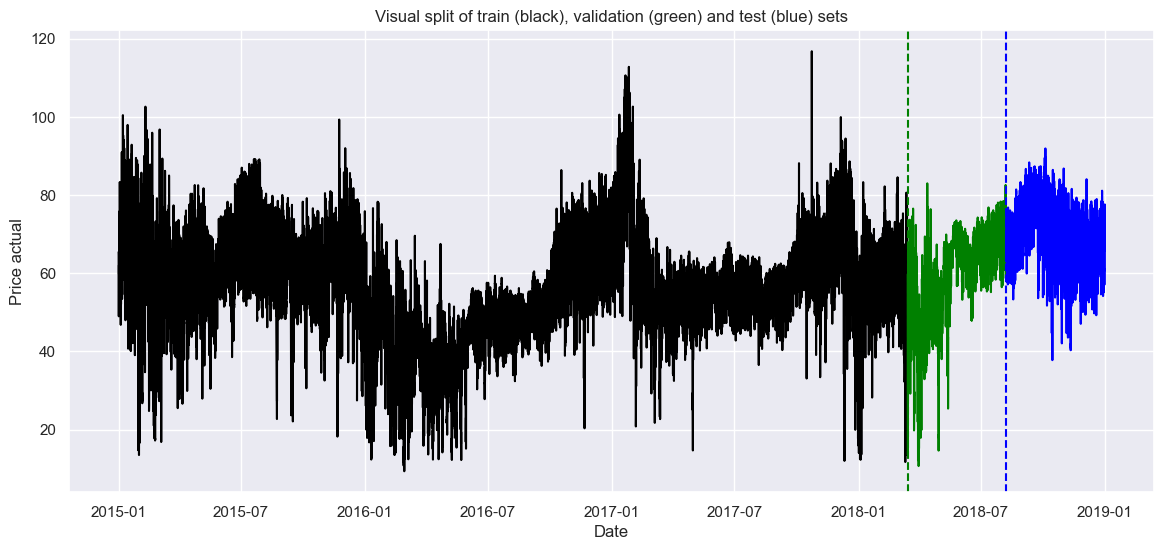

In [148]:
fig, axes = plt.subplots(figsize = (14,6))
axes.plot(df_weather_energy['price actual'].iloc[:train_cutoff], color = 'black')
axes.plot(df_weather_energy['price actual'].iloc[train_cutoff + 1 : val_cutoff], color = 'green')
axes.plot(df_weather_energy['price actual'].iloc[val_cutoff + 1 :], color = 'blue')
axes.axvline(x=df_weather_energy.index[train_cutoff], color='green', linestyle='--')
axes.axvline(x=df_weather_energy.index[val_cutoff], color='blue', linestyle='--')
axes.set_title('Visual split of train (black), validation (green) and test (blue) sets')
axes.set_xlabel('Date')
axes.set_ylabel('Price actual')
plt.show()

<h2> Forecasting </h2>

<h3> 1. XGBoost </h3>

In [149]:
def reshaping(X):
    
    reshaped_x = X.reshape(-1 , X.shape[1] * X.shape[2])
    return reshaped_x

X_train_xgb = reshaping(X_train)
X_val_xgb   = reshaping(X_val)
X_test_xgb  = reshaping(X_test)

In [153]:
X_val_xgb.shape

(3482, 384)

In [154]:
X_train.shape

(28027, 24, 16)

In [150]:
import xgboost as xgb

# Specify eval_metric in the constructor
xgb_model = xgb.XGBRegressor(
    eval_metric='rmse',
    n_estimators=100,        # you can set other params here
    learning_rate=0.1,
    subsample=1
)

# Fit the model with early stopping
xgb_model.fit(
    X_train_xgb, y_train,
    eval_set=[(X_val_xgb, y_val)],  # usually only validation set is used here
    verbose=False
)
joblib.dump(xgb_model, 'xgb_regressor.pkl')
print("✅ 'xgb_regressor.pkl' saved successfully!")


✅ 'xgb_regressor.pkl' saved successfully!


In [117]:
import matplotlib.pyplot as plt

def plot_results(y_pred_actual, y_test_inv, model, model_name, history=None):
    """
    Plot predictions vs actuals and training/validation metrics.

    Parameters:
    - y_pred_actual : np.array, predicted values (inverse scaled)
    - y_test_inv : np.array, actual values (inverse scaled)
    - model : trained model (XGBoost or other)
    - model_name : str, name of the model ('XGBoost', 'LSTM', etc.)
    - history : Keras history object (optional)
    """
    
    fig, ax = plt.subplots(2, 1, figsize=(12, 6))
    
    # Plot predictions vs actual
    ax[0].plot(y_pred_actual[:1000], label='Prediction')
    ax[0].plot(y_test_inv[:1000], label='Actual')
    ax[0].legend(loc='upper left')
    ax[0].set_title(f'Prediction vs Actual for first 1000 observations ({model_name})')
    ax[0].set_xlabel('Observation')
    ax[0].set_ylabel('Price')
    ax[0].grid(True)
    
    # Plot training/validation metrics
    if model_name.lower() != 'hybrid':
        if model_name == 'XGBoost':
            try:
                evals = model.evals_result()
                for dataset_name in evals:
                    for metric_name in evals[dataset_name]:
                        ax[1].plot(evals[dataset_name][metric_name], label=f'{dataset_name} {metric_name}')
                ax[1].legend()
                ax[1].set_title(f'Training and Validation Metrics ({model_name})')
                ax[1].set_xlabel('Iteration')
                ax[1].set_ylabel('Metric')
                ax[1].grid(True)
            except AttributeError:
                ax[1].text(0.5, 0.5, 'No evals_result available', ha='center', va='center')
        else:
            if history is not None:
                ax[1].plot(history.history['loss'], label='Training Loss')
                ax[1].plot(history.history['val_loss'], label='Validation Loss')
                ax[1].legend()
                ax[1].set_title(f'Training and Validation Loss ({model_name})')
                ax[1].set_xlabel('Epochs')
                ax[1].set_ylabel('Loss')
                ax[1].grid(True)
            else:
                ax[1].text(0.5, 0.5, 'No history available', ha='center', va='center')
    
    fig.tight_layout()
    plt.show()





---------------------------------------------------
XGBoost MAE for test set : 1.596
---------------------------------------------------



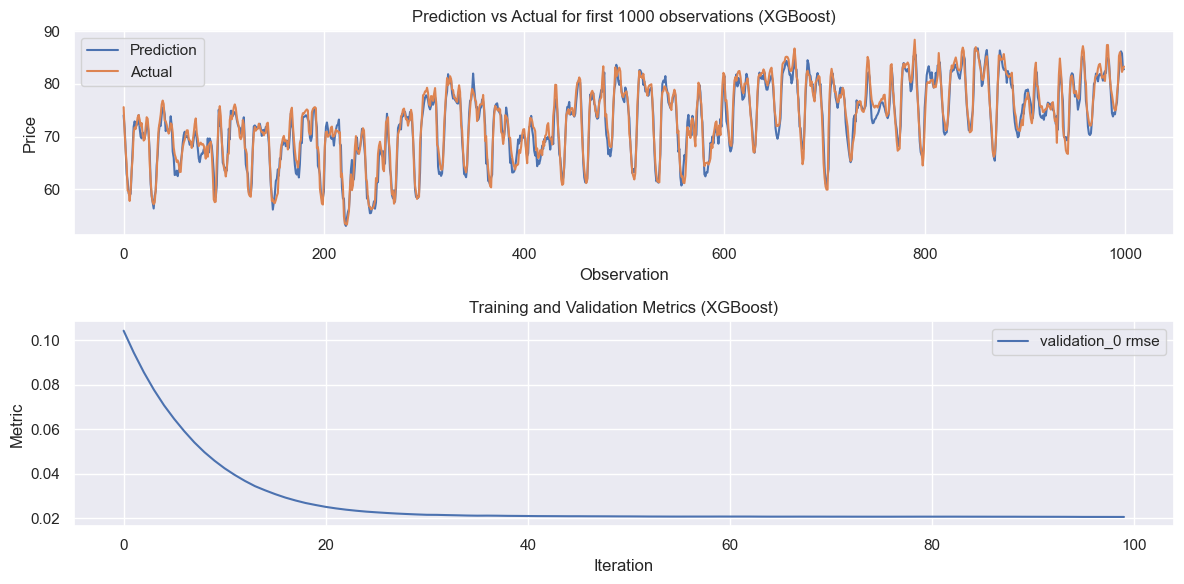

In [118]:
# Predict on test set
y_pred = xgb_model.predict(X_test_xgb)

# Reshape predictions and inverse transform
y_pred_actual = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))  # ensure shape matches

# Print MAE on test set
print('\n\n')
print('---------------------------------------------------')
print(f'XGBoost MAE for test set : {round(mean_absolute_error(y_pred_actual, y_test_inv), 3)}')
print('---------------------------------------------------\n')

# Plot results
plot_results(y_pred_actual, y_test_inv, xgb_model, 'XGBoost')


In [138]:
X_train.shape

(28027, 24, 16)

In [137]:
import numpy as np
import pandas as pd
import xgboost as xgb
import joblib

def predict_price_xgboost(input_data):
    """
    Predicts the electricity price using a trained XGBoost model.

    Args:
        input_data (np.array): A numpy array of shape (1, 18) containing the
                               most recent time step of data for all 18 features.

    Returns:
        float: The predicted electricity price.
    """
    # Load the trained model and scalers
    xgb_model = joblib.load('xgb_regressor.pkl')
    scaler_X = joblib.load('scaler_X.pkl')
    scaler_y = joblib.load('scaler_y.pkl')

    # 1. Preprocess the input data
    # The input is already in the correct 2D shape (1, 18)
    scaled_input = scaler_X.transform(input_data)

    # 2. Make a prediction with the XGBoost model
    xgb_prediction = xgb_model.predict(scaled_input)

    # 3. Inverse transform the prediction to get the actual price
    # Reshape the prediction to be 2D for the scaler
    final_prediction = scaler_y.inverse_transform(xgb_prediction.reshape(1, -1))

    # Return the single predicted value
    return final_prediction[0, 0]

# --- Example Usage ---

# Create some sample input data (replace with your actual data).
# This should be the most recent row of your feature data.
# The shape must be (1, 18).
sample_input = np.random.rand(1, 18)

# Get the prediction
predicted_price = predict_price_xgboost(sample_input)

print(f"Predicted Electricity Price (XGBoost Only): {predicted_price}")

FileNotFoundError: [Errno 2] No such file or directory: 'xgb_regressor.pkl'

In [120]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test_inv, y_pred_actual)
print("MAE:", mae)


MAE: 1.596079229266692


<h3> 2. GRU </h3>

In [121]:
def base_model_gru():
    
    model = Sequential()
    model.add(GRU(units=32, return_sequences=True, activation="relu", input_shape=X_train.shape[-2:]))
    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1))
    
    return model

gru_model = base_model_gru()


C:\Users\HARSHIL\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [127]:
# inputs for DL models
epoch = 100
batch_size = 64
steps_per_epoch = len(X_train) // batch_size

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)
optimizer = Adam( amsgrad=True)

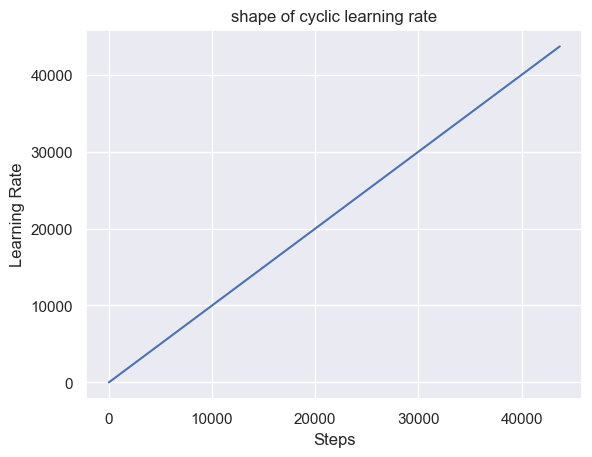

In [129]:
step = np.arange(0, epoch * steps_per_epoch)
plt.plot(step)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.title("shape of cyclic learning rate")
plt.show()


In [130]:
gru_model.compile(optimizer = optimizer , loss = 'mean_absolute_error')
history = gru_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = epoch, 
                   batch_size = batch_size, callbacks=[callback])

Epoch 1/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0628 - val_loss: 0.0455
Epoch 2/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0409 - val_loss: 0.0353
Epoch 3/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0348 - val_loss: 0.0360
Epoch 4/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0309 - val_loss: 0.0363
Epoch 5/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0279 - val_loss: 0.0308
Epoch 6/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0258 - val_loss: 0.0317
Epoch 7/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0240 - val_loss: 0.0257
Epoch 8/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0229 - val_loss: 0.0211
Epoch 9/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0219 - val_loss: 0.0210
Epoch 10/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0210 - val_loss: 0.0208
Epoch 11/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0200 - val_loss: 0.0187
Epoch 12/100
438/438 ━━━━━━━━━

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


---------------------------------------------------
GRU MAE for test set : 0.022
---------------------------------------------------



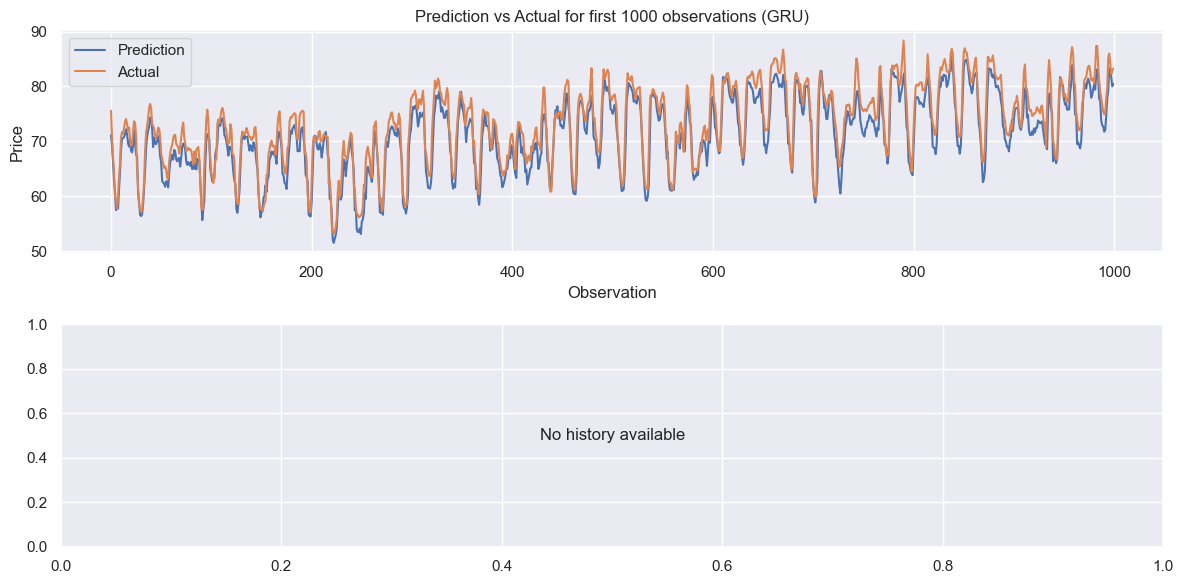

In [131]:
y_pred = gru_model.predict(X_test)
print('')
print('')
print('---------------------------------------------------')
print(f'GRU MAE for test set : {round(mean_absolute_error(y_pred,y_test),3)}')
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_pred)
print('')
plot_results(y_pred_actual, y_test_inv, history,'GRU')

<h3> 3. LSTM </h3>

In [132]:
def base_model_lstm():

    model = Sequential()
    model.add(LSTM(units = 32, return_sequences = True, activation="relu", input_shape = X_train.shape[-2:]))
    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1))
    
    return model

lstm_model = base_model_lstm()
lstm_model.compile(optimizer = optimizer , loss = 'mean_absolute_error')
lstm_model.summary()

C:\Users\HARSHIL\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 32)         │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 414,918 (1.58 MB)

 Trainable params: 104,833 (409.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 310,085 (1.18 MB)

In [133]:
history = lstm_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs =epoch, 
                   batch_size = batch_size, callbacks=[callback])

Epoch 1/100


NotImplementedError: numpy() is only available when eager execution is enabled.

In [ ]:
y_pred = lstm_model.predict(X_test)
print('')
print('')
print('---------------------------------------------------')
print(f'LSTM MAE for test set : {round(mean_absolute_error(y_pred,y_test),3)}')
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_pred)
print('')
plot_results(y_pred_actual, y_test_inv, history,'LSTM')

<h3> 4. CNN </h3>

In [123]:
def base_model_cnn():
    
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=X_train.shape[-2:]))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1))
    
    return model

cnn_model = base_model_cnn()
cnn_model.compile(optimizer = optimizer , loss = 'mean_absolute_error')
cnn_model.summary()

C:\Users\HARSHIL\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



NameError: name 'optimizer' is not defined

In [ ]:
history = cnn_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = epoch, 
                   batch_size = batch_size, callbacks=[callback])

In [ ]:
y_pred = cnn_model.predict(X_test)
print('')
print('')
print('---------------------------------------------------')
print(f'CNN MAE for test set : {round(mean_absolute_error(y_pred,y_test),3)}')
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_pred)
print('')
plot_results(y_pred_actual, y_test_inv, history,'CNN')

<h3> 5. CNN-LSTM </h3>

In [ ]:
def base_model_cnn_lstm():
    
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=X_train.shape[-2:]))
    model.add(LSTM(units = 8, return_sequences = True, activation="relu"))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1))
    
    return model

cnn_lstm_model = base_model_cnn_lstm()
cnn_lstm_model.compile(optimizer = optimizer , loss = 'mean_absolute_error')
cnn_lstm_model.summary()

In [ ]:
history = cnn_lstm_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = epoch, 
                   batch_size = batch_size, callbacks=[callback])

In [ ]:
y_pred = cnn_lstm_model.predict(X_test)
print('')
print('')
print('---------------------------------------------------')
print(f'CNN-LSTM MAE for test set : {round(mean_absolute_error(y_pred,y_test),3)}')
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_pred)
print('')
plot_results(y_pred_actual, y_test_inv, history,'CNN-LSTM')

<h3> 6. LSTM-Attention </h3>

In [ ]:
def LSTM_attention():
    inputs = Input(shape=(hist_size, X_train.shape[2]))
    #By masking the zeros, the model can learn to ignore the missing values and focus on the valid data.
    masked = Masking(mask_value=0.)(inputs)
    lstm = LSTM(132, return_sequences=True)(masked)
    attention = dot([lstm, lstm], axes=[2, 2])
    # extracting weight for every observation in the history size!
    attention = Dense(hist_size, activation='softmax')(attention)
    # assinging weight to lstm by dot product
    context = dot([attention, lstm], axes=[2, 1])
    flattened = Flatten()(context)8
    output = Dense(1)(flattened)
    model = Model(inputs=inputs, outputs=output)
    
    return model

LSTM_attention_model = LSTM_attention()
LSTM_attention_model.compile(optimizer=optimizer, loss='mae')
LSTM_attention_model.summary()


In [ ]:
history = LSTM_attention_model.fit(X_train, y_train, epochs=epoch, batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])

In [ ]:
y_pred = LSTM_attention_model.predict(X_test)
print('')
print('')

print('---------------------------------------------------')
print(f'LSTM-Attention MAE for test set : {round(mean_absolute_error(y_pred,y_test),3)}')
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_pred)
print('')
plot_results(y_pred_actual, y_test_inv, history,'LSTM-Attention')

<h3> 7. Hybrid GRU-XGBoost </h3>

In [ ]:
def base_model_gru():
    
    model = Sequential()
    model.add(GRU(units=32, return_sequences=True, activation="relu", input_shape=X_train.shape[-2:]))
    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1))
    
    return model

gru_model = base_model_gru()
gru_model.compile(optimizer = optimizer , loss = 'mean_absolute_error')

print('')
print('GRU is fitting a model on train-validation sets...')
print('')

gru_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = epoch, 
                   batch_size = batch_size, callbacks=[callback])

print('')
print('----------------------------------')
print('GRU is predicting...')
print('')

residuals_train = y_train - gru_model.predict(X_train)
residuals_val   = y_val - gru_model.predict(X_val)

print('')
print('----------------------------------')
print('XGBoost is fitting a model on residuals...')
print('')

xgb_hybrid = xgb.XGBRegressor()
xgb_hybrid.fit(X_train_xgb, residuals_train,
               eval_set=[(X_train_xgb, residuals_train), (X_val_xgb, residuals_val)],     
               eval_metric='mae',
               early_stopping_rounds=8,
               verbose=False) 


y_train_pred = gru_model.predict(X_train) + xgb_hybrid.predict(X_train_xgb).reshape(-1,1)
y_val_pred   = gru_model.predict(X_val)   + xgb_hybrid.predict(X_val_xgb).reshape(-1,1)

In [ ]:
y_test_pred  = gru_model.predict(X_test) + xgb_hybrid.predict(X_test_xgb).reshape(-1,1)
print('')
print('')

print('---------------------------------------------------')
print(f'GRU-XGBoost MAE for test set : {round(mean_absolute_error(y_test_pred,y_test),3)}')
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_test_pred)
print('')
plot_results(y_pred_actual, y_test_inv, 'hybrid' ,'hybrid GRU-XGBoost')


<h3> 8. Hybrid LSTM-Attention-XGBoost </h3>

In [ ]:
def LSTM_attention():
    inputs = Input(shape=(hist_size, X_train.shape[2]))
    #By masking the zeros, the model can learn to ignore the missing values and focus on the valid data.
    masked = Masking(mask_value=0.)(inputs)
    lstm = LSTM(132, return_sequences=True)(masked)
    attention = dot([lstm, lstm], axes=[2, 2])
    # extracting weight for every observation in the history size!
    attention = Dense(hist_size, activation='softmax')(attention)
    # assinging weight to lstm by dot product
    context = dot([attention, lstm], axes=[2, 1])
    flattened = Flatten()(context)
    output = Dense(1)(flattened)
    model = Model(inputs=inputs, outputs=output)
    
    return model

LSTM_attention_model = LSTM_attention()
LSTM_attention_model.compile(optimizer=optimizer, loss='mae')


print('')
print('LSTM-Attention is fitting a model on train-validation sets...')
print('')

LSTM_attention_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = epoch, 
                   batch_size = batch_size, callbacks=[callback])

print('')
print('----------------------------------')
print('LSTM-attention is predicting...')
print('')

residuals_train = y_train - LSTM_attention_model.predict(X_train)
residuals_val   = y_val - LSTM_attention_model.predict(X_val)

print('')
print('----------------------------------')
print('XGBoost is fitting a model on residuals...')
print('')

xgb_hybrid = xgb.XGBRegressor()
xgb_hybrid.fit(X_train_xgb, residuals_train,
               eval_set=[(X_train_xgb, residuals_train), (X_val_xgb, residuals_val)],     
               eval_metric='mae',
               early_stopping_rounds=8,
               verbose=False) 


y_train_pred = LSTM_attention_model.predict(X_train) + xgb_hybrid.predict(X_train_xgb).reshape(-1,1)
y_val_pred   = LSTM_attention_model.predict(X_val)   + xgb_hybrid.predict(X_val_xgb).reshape(-1,1)

In [ ]:
y_test_pred  = LSTM_attention_model.predict(X_test) + xgb_hybrid.predict(X_test_xgb).reshape(-1,1)
print('')
print('')

print('---------------------------------------------------')
print(f'LSTM-Attention-XGBoost MAE for test set : {round(mean_absolute_error(y_test_pred,y_test),3)}')
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_test_pred)
print('')
plot_results(y_pred_actual, y_test_inv, 'hybrid' ,'hybrid LSTM-Attention-XGBoost')

<h3> Results </h3>
<p>
</p>
The MAE (Mean Absolute Error) is used to report the results for the normalized test set: 
<p>
</p>    
<ul>    
<li> TSO prediction          : 0.070 </li>
<li> XGboost                 : 0.016 </li>
<li> GRU                     : 0.015 </li>
<li> LSTM                    : 0.018 </li>
<li> CNN                     : 0.025 </li>
<li> CNN-LSTM                : 0.019 </li>
<li> LSTM-Attention          : 0.015 </li>
<li> Hybrid GRU-XGBoost             : 0.014 </li>
<li> Hybrid LSTM-Attention-XGBoost  : 0.015 </li>    
</ul>

<strong> Note : </strong> According to the findings, the <strong> hybrid methods</strong> demonstrated better performance in terms of MAE compared to 
other methods. It is worth mentioning that all machine learning/deep learning methods outperformed TSO prediction.